## Table of Contents:
1) Feature Engineering<br>
2) KPI Selection<br>
&ensp; 2.1) Page Views<br>
&ensp;2.2) Conversion Rate<br>
&ensp;2.3) Churn Rate<br>
&ensp;2.4) Profitability<br>
&ensp;2.5) Distribution of Selected KPIs<br>
&ensp;2.6) KPI Summary<br>
3) PCA of Multicollinear Features<br>
&ensp;3.1) Price<br>
&ensp;3.2) Discount Ratio<br>
&ensp;3.3) Price to RRP Ratio<br>
&ensp;3.4) PCA Summary<br>
4) Bivariate Analysis of KPIs<br>
&ensp;4.1) Numerical Features vs KPIs<br>
&emsp; 4.1.1) Rank vs KPIs<br>
&emsp;4.1.2) RRP vs KPIs<br>
&emsp;4.1.3) Price vs KPIs<br>
&emsp;4.1.4) Discount Rate vs KPIs<br>
&emsp;4.1.5) Price to RRP Ratio vs KPIs<br>
&ensp;4.2) Categorical Features vs KPIs<br>
&emsp;4.2.1) Brand vs KPIs<br>
&emsp;4.2.2) Category 1 vs KPIs<br>
&emsp;4.2.3) Category 2 vs KPIs<br>
&emsp;4.2.4) Is_Discounted vs KPIs<br>
&ensp;4.3) Conclusion for Bivariate Analysis of KPIs<br>
5) Analysis of Pricing Levels<br>
&ensp;5.1) Numerical Features vs Pricing Metrics<br>
&emsp;5.1.1) Rank vs Pricing Metrics<br>
&emsp;5.1.2) RRP vs Pricing Metrics<br>
&emsp;5.1.3) Is_Discounted vs RRP<br>
&ensp;5.2) Categorical Features vs Pricing Metrics<br>
&emsp;5.2.1) Brand vs Pricing Metrics<br>
&emsp;5.2.2) Category 1 vs Pricing Metrics<br>
&emsp;5.2.3) Category 2 vs Pricing Metrics<br>
&ensp;5.3) Categorical Features vs Is_Discounted<br>
&emsp;5.3.1) Brand vs Is_Discounted<br>
&emsp;5.3.2) Category 1 vs Is_Discounted<br>
&emsp;5.3.4) Category 2 vs Is_Discounted<br>
&ensp;5.4) Missing Values in Pricing Features<br>
&ensp;5.5) Pricing Levels Summary<br>
6) Multivariate Analysis of KPIs<br>
&ensp;6.1) Shap Values Analysis of CatBoostRegressor<br>
&emsp;6.1.1) Page Views<br>
&emsp;6.1.2) Conversion Rate<br>
&emsp;6.1.3) Churn Rate<br>
&emsp;6.1.4) Profitability<br>
&ensp;6.2) Multivariate KPI Analysis Summary<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import shap
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import loguniform
import time
shap.initjs()

plt.style.use('seaborn')
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_excel('pricing_data.xlsx', header = 1)

df.columns

cols = df.columns[df.columns.str.contains('Price')]
df[cols] = df[cols].replace(0, np.nan)
print(df.isna().sum())

Rank               0
Category           0
Brand              0
Orders             0
Returns           46
Page Views         0
RRP                0
1Month Price      75
3 Month Price      1
6 Month Price      1
12 Month Price     1
dtype: int64


**RRP** stands for the cost of the product.

In [3]:
df.head()

,Rank,Category,Brand,Orders,Returns,Page Views,RRP,1Month Price,3 Month Price,6 Month Price,12 Month Price
0,1,phones-and-tablets/smartphones,samsung,143,67.0,13902,899.0,"79.9, 99.9","59.9, 79.9","49.9, 69.9","39.9, 59.9"
1,2,gaming-and-vr/virtual-reality,oculus,271,265.0,5019,494.0,59.9,44.9,34.9,29.9
2,3,phones-and-tablets/smartphones,samsung,288,32.0,12022,749.0,"49.9, 89.9","39.9, 69.9","29.9, 59.9","19.9, 49.9"
3,4,gaming-and-vr/virtual-reality,oculus,239,161.0,4366,494.0,59.9,44.9,34.9,29.9
4,5,gaming-and-vr/gaming-consoles,nintendo,299,244.0,7842,346.0,34.9,24.9,19.9,17.9


# 1) Feature Engineering

We will do feature engineering to capture more information and turn features into more explainable form. First we will start with numerical columns:<br>
1) We will separate Price columns into discounted and non-discounted prices and turn them into floats.<br>
2) We will create a new column explaining discount ratios for each subscription period.<br>
3) We will also add a new column explaining whether there is a discount for each subscription period.<br>
4) We will create a new column giving price to RRP ratio for each newly created price column in step 1. <br>
<br>
For categorical columns:<br>
1) We will separate category into two being main and sub categories named category_1 and category_2.<br>

In [4]:
#Get 2 separate columns for discounted and pre-discounted price for each subscription type
df[['1m_price_disc','1m_price']] = df['1Month Price'].str.split(',', expand = True).astype('float')
df[['3m_price_disc','3m_price']] = df['3 Month Price'].str.split(',', expand = True).astype('float')
df[['6m_price_disc','6m_price']] = df['6 Month Price'].str.split(',', expand = True).astype('float')
df[['12m_price_disc','12m_price']] = df['12 Month Price'].str.split(',', expand = True).astype('float')
df = df.drop(['1Month Price', '3 Month Price', '6 Month Price','12 Month Price'], axis = 1)


#Fill pre-discounted price where there is no discount
mask = df['1m_price'].isna()
df.loc[mask, '1m_price'] = df.loc[mask, '1m_price_disc']
mask = df['3m_price'].isna()
df.loc[mask, '3m_price'] = df.loc[mask, '3m_price_disc']
mask = df['6m_price'].isna()
df.loc[mask, '6m_price'] = df.loc[mask, '6m_price_disc']
mask = df['12m_price'].isna()
df.loc[mask, '12m_price'] = df.loc[mask, '12m_price_disc']


#Discount ratios
df['1m_disc_ratio'] = 1 - df['1m_price_disc'] / df['1m_price']
df['3m_disc_ratio'] = 1 - df['3m_price_disc'] / df['3m_price']
df['6m_disc_ratio'] = 1 - df['6m_price_disc'] / df['6m_price']
df['12m_disc_ratio'] = 1 - df['12m_price_disc'] / df['12m_price']


#is_discounted
cols = ['1m_disc_ratio', '3m_disc_ratio', '6m_disc_ratio', '12m_disc_ratio']
df_temp = df[cols].copy()
df_temp = df_temp.fillna(0)
df['is_discounted'] = (df_temp != 0).sum(axis=1) > 0


#RRP ratios
cols = df.columns[df.columns.str.contains('price')]
for col in cols:
    df[f'{col}_RRP_ratio'] = df[col].astype('float') / df['RRP']


df.head()

,Rank,Category,Brand,Orders,Returns,Page Views,RRP,1m_price_disc,1m_price,3m_price_disc,3m_price,6m_price_disc,6m_price,12m_price_disc,12m_price,1m_disc_ratio,3m_disc_ratio,6m_disc_ratio,12m_disc_ratio,is_discounted,1m_price_disc_RRP_ratio,1m_price_RRP_ratio,3m_price_disc_RRP_ratio,3m_price_RRP_ratio,6m_price_disc_RRP_ratio,6m_price_RRP_ratio,12m_price_disc_RRP_ratio,12m_price_RRP_ratio
0,1,phones-and-tablets/smartphones,samsung,143,67.0,13902,899.0,79.9,99.9,59.9,79.9,49.9,69.9,39.9,59.9,0.200200,0.250313,0.286123,0.333890,True,0.088877,0.111123,0.066630,0.088877,0.055506,0.077753,0.044383,0.066630
1,2,gaming-and-vr/virtual-reality,oculus,271,265.0,5019,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,False,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526
2,3,phones-and-tablets/smartphones,samsung,288,32.0,12022,749.0,49.9,89.9,39.9,69.9,29.9,59.9,19.9,49.9,0.444939,0.429185,0.500835,0.601202,True,0.066622,0.120027,0.053271,0.093324,0.039920,0.079973,0.026569,0.066622
3,4,gaming-and-vr/virtual-reality,oculus,239,161.0,4366,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,False,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526
4,5,gaming-and-vr/gaming-consoles,nintendo,299,244.0,7842,346.0,34.9,34.9,24.9,24.9,19.9,19.9,17.9,17.9,0.000000,0.000000,0.000000,0.000000,False,0.100867,0.100867,0.071965,0.071965,0.057514,0.057514,0.051734,0.051734


In [5]:
#Separate main and sub-categories
print('if 1.0 ==',df['Category'].str.contains('/').mean(),'then we can say each case has 2 categories')
print()
df[['category_1', 'category_2']] = df['Category'].str.split('/', expand = True)
print(len(df['category_2'].value_counts()), len(df['Category'].value_counts()))
print()
print(df['Category'].value_counts())
print()
print(df['category_1'].value_counts())
print()
print(df['category_2'].value_counts())
df = df.drop('Category', axis = 1)
df.head()

if 1.0 == 1.0 then we can say each case has 2 categories

43 43

computers/laptops                       325
audio-and-music/headphones              144
phones-and-tablets/tablets              131
computers/gaming-computers              122
phones-and-tablets/smartphones          120
cameras/lenses                          120
computers/desktop-computers             109
cameras/digital-cameras                 105
audio-and-music/hi-fi-audio              86
home-entertainment/tv                    72
computers/monitors                       72
wearables/apple-watches                  69
audio-and-music/bluetooth-speakers       63
computers/2-in-1-laptops                 61
home-entertainment/home-cinema           54
home-entertainment/projectors            52
audio-and-music/dj-equipment             40
computers/computer-accessories           38
wearables/smartwatches                   37
cameras/action-cameras                   34
gaming-and-vr/virtual-reality            33
drones/for-

,Rank,Brand,Orders,Returns,Page Views,RRP,1m_price_disc,1m_price,3m_price_disc,3m_price,6m_price_disc,6m_price,12m_price_disc,12m_price,1m_disc_ratio,3m_disc_ratio,6m_disc_ratio,12m_disc_ratio,is_discounted,1m_price_disc_RRP_ratio,1m_price_RRP_ratio,3m_price_disc_RRP_ratio,3m_price_RRP_ratio,6m_price_disc_RRP_ratio,6m_price_RRP_ratio,12m_price_disc_RRP_ratio,12m_price_RRP_ratio,category_1,category_2
0,1,samsung,143,67.0,13902,899.0,79.9,99.9,59.9,79.9,49.9,69.9,39.9,59.9,0.200200,0.250313,0.286123,0.333890,True,0.088877,0.111123,0.066630,0.088877,0.055506,0.077753,0.044383,0.066630,phones-and-tablets,smartphones
1,2,oculus,271,265.0,5019,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,False,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526,gaming-and-vr,virtual-reality
2,3,samsung,288,32.0,12022,749.0,49.9,89.9,39.9,69.9,29.9,59.9,19.9,49.9,0.444939,0.429185,0.500835,0.601202,True,0.066622,0.120027,0.053271,0.093324,0.039920,0.079973,0.026569,0.066622,phones-and-tablets,smartphones
3,4,oculus,239,161.0,4366,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,False,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526,gaming-and-vr,virtual-reality
4,5,nintendo,299,244.0,7842,346.0,34.9,34.9,24.9,24.9,19.9,19.9,17.9,17.9,0.000000,0.000000,0.000000,0.000000,False,0.100867,0.100867,0.071965,0.071965,0.057514,0.057514,0.051734,0.051734,gaming-and-vr,gaming-consoles


In [6]:
df.dtypes

Rank                          int64
Brand                        object
Orders                        int64
Returns                     float64
Page Views                    int64
RRP                         float64
1m_price_disc               float64
1m_price                    float64
3m_price_disc               float64
3m_price                    float64
6m_price_disc               float64
6m_price                    float64
12m_price_disc              float64
12m_price                   float64
1m_disc_ratio               float64
3m_disc_ratio               float64
6m_disc_ratio               float64
12m_disc_ratio              float64
is_discounted                  bool
1m_price_disc_RRP_ratio     float64
1m_price_RRP_ratio          float64
3m_price_disc_RRP_ratio     float64
3m_price_RRP_ratio          float64
6m_price_disc_RRP_ratio     float64
6m_price_RRP_ratio          float64
12m_price_disc_RRP_ratio    float64
12m_price_RRP_ratio         float64
category_1                  

Here we see that some RRP_ratio columns has **inf numbers due to zero-division**. We will replace them with Nans to ignore those cases while plotting. We can also see that Orders, Returns and Page Views has a **sparsity** problem i.e. they have many cases with 0 value. We should keep that in mind while analyzing their distributions.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,2139.0,1070.000000,617.620434,1.000000,535.500000,1070.000000,1604.500000,2.139000e+03
Orders,2139.0,6.860683,28.967810,0.000000,0.000000,0.000000,2.000000,4.600000e+02
Returns,2093.0,5.511228,22.041385,0.000000,0.000000,0.000000,2.000000,4.120000e+02
Page Views,2139.0,312.669004,1041.865300,0.000000,14.000000,59.000000,194.000000,1.600300e+04
RRP,2139.0,820.191398,726.306043,0.000000,286.000000,579.000000,1147.000000,4.834000e+03
1m_price_disc,2064.0,88.236725,65.575860,9.900000,39.900000,69.900000,129.900000,4.599000e+02
1m_price,2064.0,88.915988,65.864284,9.900000,39.900000,69.900000,129.900000,4.599000e+02
3m_price_disc,2138.0,65.671282,51.962979,4.900000,24.900000,49.900000,89.900000,3.599000e+02
3m_price,2138.0,66.280262,52.232436,4.900000,24.900000,49.900000,89.900000,3.599000e+02
6m_price_disc,2138.0,55.871936,45.244629,3.900000,19.900000,39.900000,79.900000,3.199000e+02


In [8]:
#There are zero-division cases in the generated features thus we will replace inf values with Nan
df = df.replace(np.inf, np.nan)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,2139.0,1070.000000,617.620434,1.000000,535.500000,1070.000000,1604.500000,2139.000000
Orders,2139.0,6.860683,28.967810,0.000000,0.000000,0.000000,2.000000,460.000000
Returns,2093.0,5.511228,22.041385,0.000000,0.000000,0.000000,2.000000,412.000000
Page Views,2139.0,312.669004,1041.865300,0.000000,14.000000,59.000000,194.000000,16003.000000
RRP,2139.0,820.191398,726.306043,0.000000,286.000000,579.000000,1147.000000,4834.000000
1m_price_disc,2064.0,88.236725,65.575860,9.900000,39.900000,69.900000,129.900000,459.900000
1m_price,2064.0,88.915988,65.864284,9.900000,39.900000,69.900000,129.900000,459.900000
3m_price_disc,2138.0,65.671282,51.962979,4.900000,24.900000,49.900000,89.900000,359.900000
3m_price,2138.0,66.280262,52.232436,4.900000,24.900000,49.900000,89.900000,359.900000
6m_price_disc,2138.0,55.871936,45.244629,3.900000,19.900000,39.900000,79.900000,319.900000


# 2) KPI Selection

Currently we have 3 features regarding to KPIs which are Orders, Returns and Page Views. We will analyze them and transform/create to have more useful KPIs. When we check their correlation we see that they are highly correlated. It is possibly due to the process which a customer faces. Firstly a customer lands on a product page which increases **Page View**. Then he/she decides to buy or not and it affects **Orders** feature. Lastly he/she may decide to return product and end subscription which is captured by **Returns** feature.<br>
We will also create a function to return 4 types of distribution plots of KPIs. First one is distribution of whole data, second one excludes 0 values, third one applies logarithmic 10 scale to whole data and last one will exclude 0 values and at the same time will apply logarithmic 10 scale to the data.

In [9]:
cols = ['Orders','Returns', 'Page Views']
df[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Orders,2139.0,6.860683,28.967810,0.0,0.0,0.0,2.0,460.0
Returns,2093.0,5.511228,22.041385,0.0,0.0,0.0,2.0,412.0
Page Views,2139.0,312.669004,1041.865300,0.0,14.0,59.0,194.0,16003.0


In [10]:
df[cols].corr()

,Orders,Returns,Page Views
Orders,1.000000,0.860881,0.879700
Returns,0.860881,1.000000,0.724697
Page Views,0.879700,0.724697,1.000000


In [11]:
#A function to draw distribution plots
def kpi_plot(col_name):
    plt.figure(figsize = (10,6))

    plt.subplot(2,2,1)
    sns.histplot(df[col_name],kde=True)

    plt.subplot(2,2,2)
    #Add an epsilon value to prevent log(0) cases
    eps = 0.0001
    sns.histplot( np.log10(df[col_name] + eps), kde=True)

    
    
    mask = df[col_name] != 0
    df_plot = df[mask].copy()
    

    plt.subplot(2,2,3)
    sns.histplot(df_plot[col_name],kde=True)

    plt.subplot(2,2,4)
    eps = 0.0001
    sns.histplot( np.log10(df_plot[col_name] + eps), kde=True)
    
    plt.tight_layout()
    
    return

In [12]:
#A function to draw distribution plots
def kpi_plot(col_name):
    fig = plt.figure(figsize = (10,6))

    ax = plt.subplot(2,2,1)
    sns.histplot(df[col_name],kde=True)
    ax.set_title('Raw Distribution', fontsize = 14)
    
    ax = plt.subplot(2,2,2)
    #Add an epsilon value to prevent log(0) cases
    eps = 0.0001
    sns.histplot( np.log10(df[col_name] + eps), kde=True)
    ax.set_title('Log Distribution', fontsize = 14)

    
    
    mask = df[col_name] != 0
    df_plot = df[mask].copy()
    

    ax = plt.subplot(2,2,3)
    sns.histplot(df_plot[col_name],kde=True)
    ax.set_title('Raw Distribution without Zeros', fontsize = 14)


    ax = plt.subplot(2,2,4)
    eps = 0.0001
    sns.histplot( np.log10(df_plot[col_name] + eps), kde=True)
    ax.set_title('Log Distribution without Zeros', fontsize = 14)

    fig.suptitle(f'Distributions of {col_name}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()
    
    return

## 2.1) Page Views

Below we can see the sparsity problem that is why we will exclude 0 values. Moreover logarithmic scale has a bell shaped distribution much similar to normal distribution compared to non-logarithmic scale. Therefore we will use Page Views KPI with logarithm applied to non-zero values.

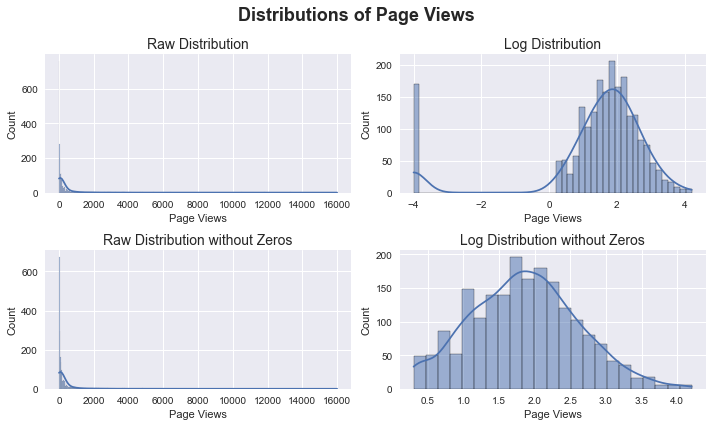

In [13]:
kpi_plot('Page Views')

## 2.2) Conversion Rate

Our second KPI is related to Orders. However Orders feature itself does not have a beautiful distribution whereas, Orders to Page Views ratio, which we call conversion_rate in our analysis has a distribution much similar to normal distribution when its sparsity is removed and logarithmic scale is applied. So we will continue with conversion rate as second KPI.

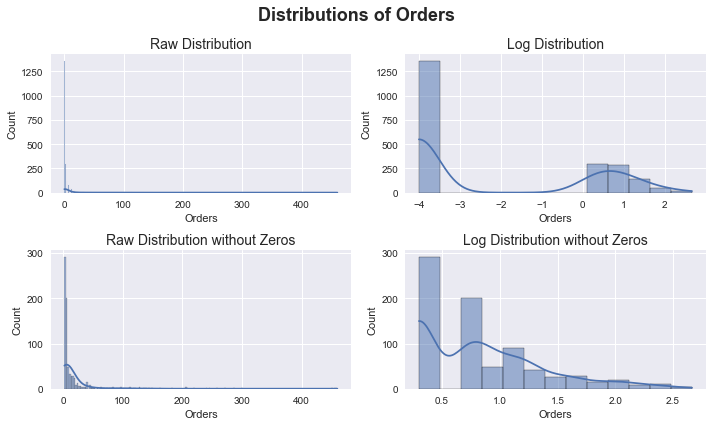

In [14]:
kpi_plot('Orders')

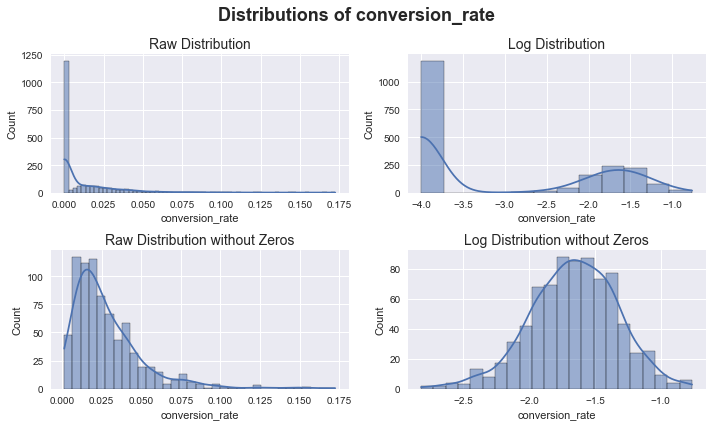

In [15]:
#conversion_rate = Orders / Page Views
df['conversion_rate'] = df['Orders'] / df['Page Views']

kpi_plot('conversion_rate')

## 2.3) Churn Rate

Our third KPI is related to Returns which we would want to decrease or take adequate measures against it. As we mentioned earlier, a customer faces a process where he or she lands to a product page then decides whether to buy lastly may or may not return the product. So we will check the distribution of Returns itself, Returns to Page Views ratio and Returns to Orders ratio. Finally we will see that Returns to Page Views ratio which we will call as churn rate has a distribution much similar to normal distribution when we apply logarithmic scale to its non-zero cases.

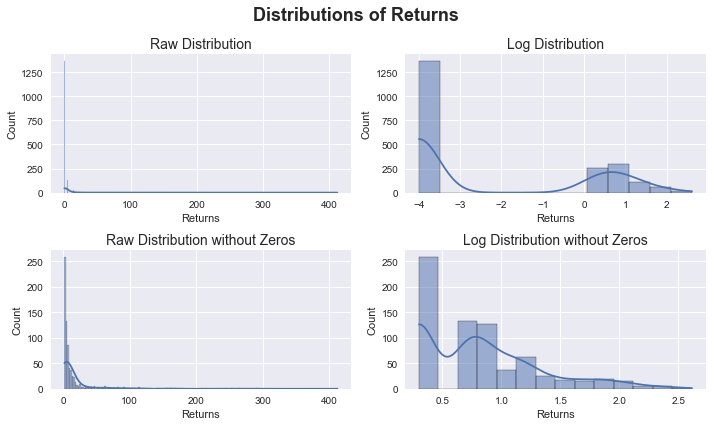

In [16]:
kpi_plot('Returns')

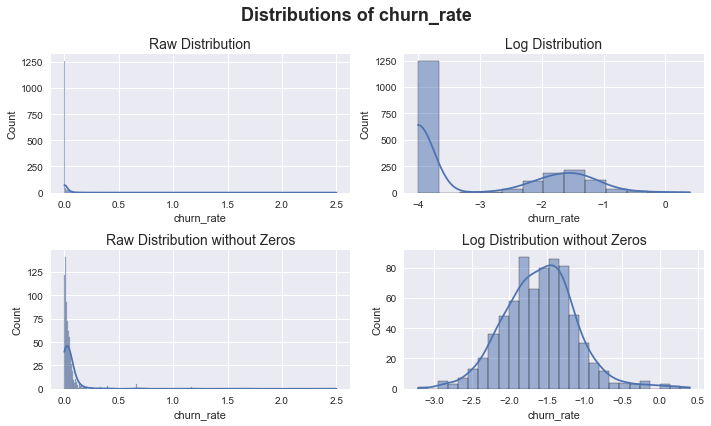

In [17]:
df['churn_rate'] = df['Returns'] / df['Page Views']

kpi_plot('churn_rate')

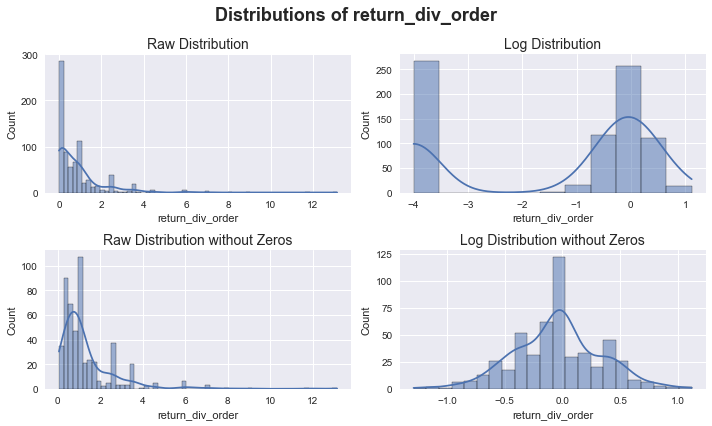

In [18]:
df['return_div_order'] = df['Returns'] / df['Orders']
kpi_plot('return_div_order')

In [19]:
#Selected churn rate as KPI, drop the other one
df = df.drop('return_div_order',axis = 1)

## 2.4) Profitability

Our last KPI will be related to profitability where we will create a new feature as Orders x Average Price / RRP. One caveat to average price is that we dont have order counts for each subscription instead we have total number of orders. So we will assume that each subscription for a product has equal number of orders.

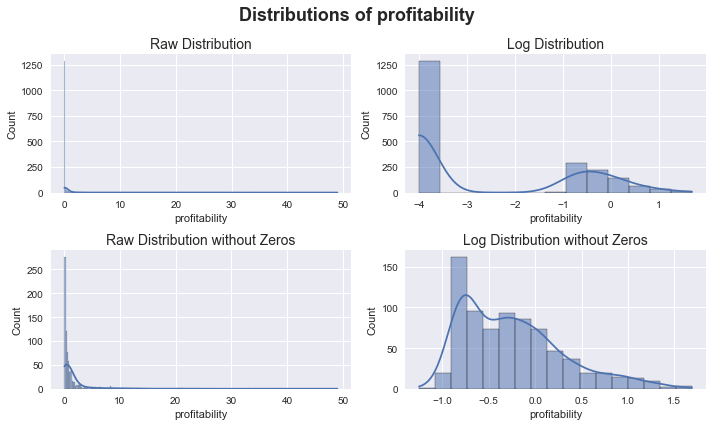

In [20]:
#profitability = orders x avg. price / RRP
#For avg. price we assume each type of subscription (1m, 3m etc.) has the same amount of orders.
df['profitability'] = (df['Orders'] * (df['1m_price_disc'] + df['3m_price_disc'] + df['6m_price_disc'] + df['12m_price_disc'])/4
                       / df['RRP'])
kpi_plot('profitability')

## 2.5) Distributions of Selected KPIs

By the result of describe function we see that some KPIs have inf values due to zero division cases. To prevent them disrupt our plots we will replace them with Nans. We will also ignore sparse i.e. 0 values for each KPI and apply logarithmic scale to each KPI. Below, you can see the final distributions of selected KPIs.

In [21]:
kpi_cols = ['Page Views', 'conversion_rate','churn_rate','profitability']
df[kpi_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Page Views,2139.0,312.669004,1041.8653,0.0,14.0,59.0,194.000000,16003.0
conversion_rate,1970.0,inf,NaN,0.0,0.0,0.0,0.017391,inf
churn_rate,1973.0,inf,NaN,0.0,0.0,0.0,0.015571,inf
profitability,2056.0,inf,NaN,0.0,0.0,0.0,0.238779,inf


In [22]:
df[kpi_cols] = df[kpi_cols].replace(np.inf,np.nan)
df[kpi_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Page Views,2139.0,312.669004,1041.865300,0.0,14.0,59.0,194.000000,16003.000000
conversion_rate,1969.0,0.011366,0.020314,0.0,0.0,0.0,0.017391,0.172414
churn_rate,1969.0,0.020867,0.100151,0.0,0.0,0.0,0.015385,2.500000
profitability,2055.0,0.596364,2.490128,0.0,0.0,0.0,0.238435,48.964467


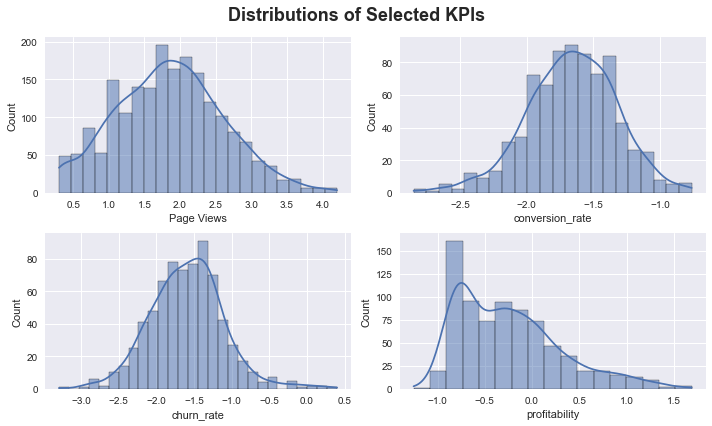

In [23]:
fig = plt.figure(figsize = (10,6))
for i,col in enumerate(kpi_cols):
    
    mask = df[col] != 0
    df_plot = df[mask].copy()
    
    plt.subplot(2,2,i+1)

    sns.histplot(np.log10(df_plot[col]), kde = True)
    
fig.suptitle('Distributions of Selected KPIs', fontsize = 18, fontweight = 'bold')
plt.tight_layout()

In [24]:
#Group columns as kpi, categorical and numerical and rearrange column orders
categorical_cols = ['Brand','category_1','category_2', 'is_discounted']
numerical_cols = [col for col in df.columns if (col not in kpi_cols) and (col not in categorical_cols) ]
print(len(df.columns) ,'==', len(kpi_cols) + len(categorical_cols) + len(numerical_cols))
df[numerical_cols + kpi_cols] = df[numerical_cols + kpi_cols].astype('float')

#Rearrange column orders
df = df[categorical_cols + numerical_cols + kpi_cols]
print(df.dtypes)
df.head()

32 == 32
Brand                        object
category_1                   object
category_2                   object
is_discounted                  bool
Rank                        float64
Orders                      float64
Returns                     float64
RRP                         float64
1m_price_disc               float64
1m_price                    float64
3m_price_disc               float64
3m_price                    float64
6m_price_disc               float64
6m_price                    float64
12m_price_disc              float64
12m_price                   float64
1m_disc_ratio               float64
3m_disc_ratio               float64
6m_disc_ratio               float64
12m_disc_ratio              float64
1m_price_disc_RRP_ratio     float64
1m_price_RRP_ratio          float64
3m_price_disc_RRP_ratio     float64
3m_price_RRP_ratio          float64
6m_price_disc_RRP_ratio     float64
6m_price_RRP_ratio          float64
12m_price_disc_RRP_ratio    float64
12m_price_RRP_ratio

,Brand,category_1,category_2,is_discounted,Rank,Orders,Returns,RRP,1m_price_disc,1m_price,3m_price_disc,3m_price,6m_price_disc,6m_price,12m_price_disc,12m_price,1m_disc_ratio,3m_disc_ratio,6m_disc_ratio,12m_disc_ratio,1m_price_disc_RRP_ratio,1m_price_RRP_ratio,3m_price_disc_RRP_ratio,3m_price_RRP_ratio,6m_price_disc_RRP_ratio,6m_price_RRP_ratio,12m_price_disc_RRP_ratio,12m_price_RRP_ratio,Page Views,conversion_rate,churn_rate,profitability
0,samsung,phones-and-tablets,smartphones,True,1.0,143.0,67.0,899.0,79.9,99.9,59.9,79.9,49.9,69.9,39.9,59.9,0.200200,0.250313,0.286123,0.333890,0.088877,0.111123,0.066630,0.088877,0.055506,0.077753,0.044383,0.066630,13902.0,0.010286,0.004819,9.130367
1,oculus,gaming-and-vr,virtual-reality,False,2.0,271.0,265.0,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526,5019.0,0.053995,0.052799,23.259919
2,samsung,phones-and-tablets,smartphones,True,3.0,288.0,32.0,749.0,49.9,89.9,39.9,69.9,29.9,59.9,19.9,49.9,0.444939,0.429185,0.500835,0.601202,0.066622,0.120027,0.053271,0.093324,0.039920,0.079973,0.026569,0.066622,12022.0,0.023956,0.002662,13.419493
3,oculus,gaming-and-vr,virtual-reality,False,4.0,239.0,161.0,494.0,59.9,59.9,44.9,44.9,34.9,34.9,29.9,29.9,0.000000,0.000000,0.000000,0.000000,0.121255,0.121255,0.090891,0.090891,0.070648,0.070648,0.060526,0.060526,4366.0,0.054741,0.036876,20.513360
4,nintendo,gaming-and-vr,gaming-consoles,False,5.0,299.0,244.0,346.0,34.9,34.9,24.9,24.9,19.9,19.9,17.9,17.9,0.000000,0.000000,0.000000,0.000000,0.100867,0.100867,0.071965,0.071965,0.057514,0.057514,0.051734,0.051734,7842.0,0.038128,0.031115,21.085549


## 2.6) KPI Summary

In this part we have selected 4 KPIs: page views, conversion rate, churn rate, profitability. Due to their sparsity we will exclude 0 values for our further analysis and apply logarithmic scale to make them have a distribution similar to normal distribution.

# 3) PCA of Multicollinear Features

By checking correlation heatmap of numerical features we can see there are **3 highly correlated clusters of features**. First cluster is prices of subscriptions, second cluster is discount ratios of subscriptions last cluster is price to RRP ratios of subscriptions. To keep analysis to the point we will use principal component analysis to those clusters of features to reduce them into a single feature for each cluster. This method will also be beneficial for our multivariate analysis with CatBoostRegressor. Even though boosting algorithms can perform pretty good in case of multicollinearity since we do not have too much data the estimator may perform poorly due to curse of dimensionality.<br> We will also print out captured variance of cluster of features by a single PCA feature to check whether we keep most of the information available. On top of that we will use MinMaxScaler and multiply it by max value of adequate cluster's 1 month subscription feature to keep those newly generated features to a similar scale to the cluster features.

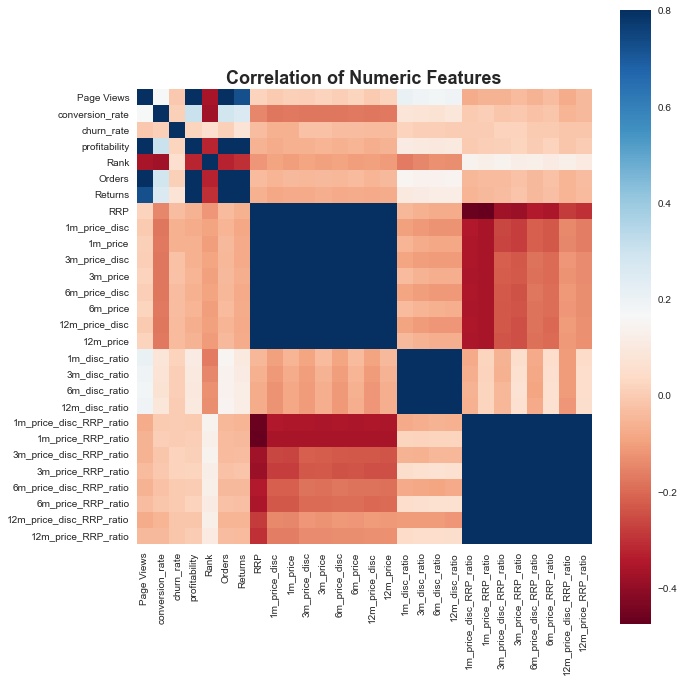

In [25]:
#Correlations
df_corr = df[kpi_cols + numerical_cols].corr()

#Correlation Heatmap
plt.subplots(figsize = (10,10))
plt.title('Correlation of Numeric Features',y=1,size=18, fontweight = 'bold')
sns.heatmap(df_corr,square = True,  vmax=0.8, cmap = 'RdBu')
plt.tight_layout()

In [26]:
price_cols = ['1m_price_disc', '1m_price', '3m_price_disc', '3m_price',
              '6m_price_disc', '6m_price', '12m_price_disc', '12m_price']

disc_ratio_cols = ['1m_disc_ratio', '3m_disc_ratio', '6m_disc_ratio', '12m_disc_ratio']

RRP_ratio_cols = ['1m_price_disc_RRP_ratio', '1m_price_RRP_ratio','3m_price_disc_RRP_ratio', '3m_price_RRP_ratio',
          '6m_price_disc_RRP_ratio', '6m_price_RRP_ratio','12m_price_disc_RRP_ratio', '12m_price_RRP_ratio']

## 3.1) Price

In [27]:
pca = PCA()

df_pca = df[price_cols].fillna(0)
pca_output = pd.DataFrame(pca.fit_transform(df_pca))
print('Captured variance ratio by a single PCA column =',round(pca.explained_variance_ratio_[0],2))

#Rescale PCA output to 1m_price to make it more interpretable
scaler = MinMaxScaler()
df['price'] = scaler.fit_transform(pca_output.iloc[:,0].values.reshape(-1,1)) * df['1m_price_disc'].max()
df['price'].head()

Captured variance ratio by a single PCA column = 0.95


0    85.103259
1    52.753888
2    64.173162
3    52.753888
4    28.906450
Name: price, dtype: float64

## 3.2) Discount Ratio

In [28]:
pca = PCA()

df_pca = df[disc_ratio_cols].fillna(0)
pca_output = pd.DataFrame(pca.fit_transform(df_pca))
print('Captured variance ratio by a single PCA column =',round(pca.explained_variance_ratio_[0],2))

#Rescale PCA output to 1m_disc_ratio to make it more interpretable
scaler = MinMaxScaler()
df['disc_ratio'] = scaler.fit_transform(pca_output.iloc[:,0].values.reshape(-1,1)) * df['1m_disc_ratio'].max()
df['disc_ratio'].head()

Captured variance ratio by a single PCA column = 0.93


0    2.436790e-01
1    7.315555e-15
2    4.449388e-01
3    1.852430e-17
4    0.000000e+00
Name: disc_ratio, dtype: float64

## 3.3) Price to RRP Ratio

In [29]:
pca = PCA()

df_pca = df[RRP_ratio_cols].fillna(0)
pca_output = pd.DataFrame(pca.fit_transform(df_pca))
print('Captured variance ratio by a single PCA column =',round(pca.explained_variance_ratio_[0],2))

#Rescale PCA output to 1m_price_disc_RRP_ratio to make it more interpretable
scaler = MinMaxScaler()
df['RRP_ratio'] = scaler.fit_transform(pca_output.iloc[:,0].values.reshape(-1,1)) * df['1m_price_disc_RRP_ratio'].max()
df['RRP_ratio'].head()

Captured variance ratio by a single PCA column = 0.9


0    0.100151
1    0.116595
2    0.092203
3    0.116595
4    0.095854
Name: RRP_ratio, dtype: float64

## 3.4) PCA Summary

We have created 3 new features, each of them capturing more than 90% of the cluster variance namely price, disc_ratio and RRP_ratio. We have also rescaled these 3 new features into a similar scale of the cluster values.

In [30]:
df[['price','disc_ratio','RRP_ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,2139.0,80.527570,65.022190,0.0,30.940566,59.483540,116.840462,459.900000
disc_ratio,2139.0,0.010894,0.041088,0.0,0.000000,0.000000,0.000000,0.444939
RRP_ratio,2139.0,0.121475,0.048443,0.0,0.096213,0.113926,0.136299,0.956558


# 4) Bivariate Analysis of KPIs

We will analyze effect of both numerical and categorical variables on KPIs. First we will look into effect of each numerical variable on 4 KPIs by plotting their respective regplots. Then for categorical variables we will analyze boxplots of top 10 most populated categories for each categorical feature. 

## 4.1) Numerical Features vs KPIs

We see that disc_ratio has a problem of sparsity so we will replace 0 values with Nans to ignore those cases on plots. Also we will use logarithmic scale to numerical features to make them have a gaussian distribution. However since Rank feature has a uniform distribution we will not apply logarithmic scale to it.

In [31]:
drop_cols = price_cols + disc_ratio_cols + RRP_ratio_cols
drop_cols

numerical_cols_to_plot = ['Rank','RRP', 'price', 'disc_ratio','RRP_ratio']

df[numerical_cols_to_plot].head()

,Rank,RRP,price,disc_ratio,RRP_ratio
0,1.0,899.0,85.103259,2.436790e-01,0.100151
1,2.0,494.0,52.753888,7.315555e-15,0.116595
2,3.0,749.0,64.173162,4.449388e-01,0.092203
3,4.0,494.0,52.753888,1.852430e-17,0.116595
4,5.0,346.0,28.906450,0.000000e+00,0.095854


In [32]:
df[numerical_cols_to_plot].describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,2139.0,1070.000000,617.620434,1.0,535.500000,1070.000000,1604.500000,2139.000000
RRP,2139.0,820.191398,726.306043,0.0,286.000000,579.000000,1147.000000,4834.000000
price,2139.0,80.527570,65.022190,0.0,30.940566,59.483540,116.840462,459.900000
disc_ratio,2139.0,0.010894,0.041088,0.0,0.000000,0.000000,0.000000,0.444939
RRP_ratio,2139.0,0.121475,0.048443,0.0,0.096213,0.113926,0.136299,0.956558


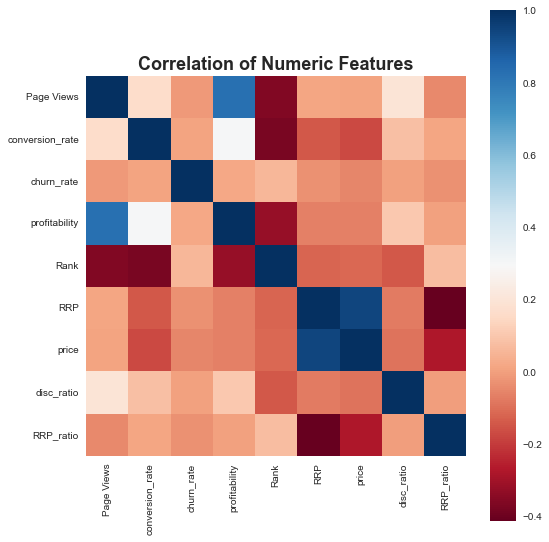

In [33]:
#Correlations
df_corr = df[kpi_cols + numerical_cols_to_plot].corr()

#Correlation Heatmap
plt.subplots(figsize = (8,8))
plt.title('Correlation of Numeric Features',y=1,size=18, fontweight = 'bold')
sns.heatmap(df_corr,square = True, cmap = 'RdBu')
plt.tight_layout()

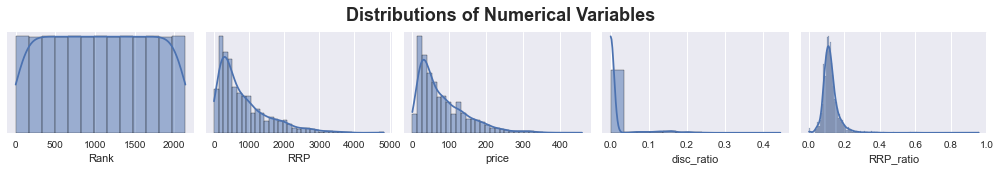

In [34]:
#Distribution plots of numerical columns
fig = plt.figure(figsize = (14,10))

for i,col in enumerate(numerical_cols_to_plot):
    
    plt.subplot(5,5,i+1)
    plt.yticks([])
    sns.histplot(df[col], kde = True)

fig.suptitle('Distributions of Numerical Variables', fontsize = 18, fontweight = 'bold')
plt.tight_layout()


In [35]:
#disc_ratio column contains so many 0 thus, to reduce its sparsity we will replace 0s with Nans. In this manner, we will
#exclude those cases on plots
df_plot = df.copy()
mask = df['disc_ratio'] < 0.001
df_plot.loc[mask,'disc_ratio'] = 0

df_plot['disc_ratio'] = df_plot['disc_ratio'].replace(0,np.nan)

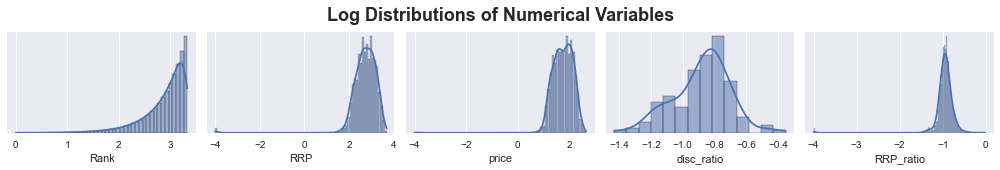

In [36]:
#Let's check logarithmic version of numerical columns to fix right skewness
fig = plt.figure(figsize = (14,10))

for i,col in enumerate(numerical_cols_to_plot):
    
    plt.subplot(5,5,i+1)
    plt.yticks([])
    #Adding a small number (0.00001) to prevent log(0) cases
    eps =  0.0001
    sns.histplot(np.log10(df_plot[col] + eps), kde = True) 

fig.suptitle('Log Distributions of Numerical Variables', fontsize = 18, fontweight = 'bold')
plt.tight_layout()


We see long tails for RRP, price and RRP_ratio, we will replace outlier values with Nans on plots to ignore them. After this step we obtain good gaussian distributions on aforementioned features.

In [37]:
#Remove outliers in defined columns
for col in ['RRP', 'price', 'RRP_ratio']:
    temp = np.log10(df_plot[col])
    mask = temp.between(temp.quantile(0.005), temp.quantile(0.995))
    df_plot.loc[~mask] = np.nan

divide by zero encountered in log10


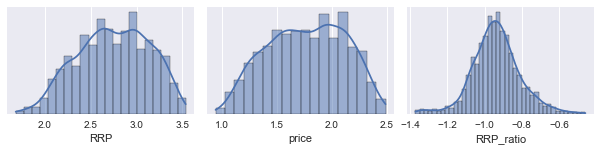

In [38]:
#Distribution plots of numerical columns
plt.figure(figsize = (14,10))

for i,col in enumerate(['RRP', 'price', 'RRP_ratio']):
    
    plt.subplot(5,5,i+1)
    plt.yticks([])
    sns.histplot(np.log10(df_plot[col]), kde = True)

plt.tight_layout()


In [39]:
def kpi_regplot(num_col):

    fig = plt.figure(figsize = (10,10))
    for i,col in enumerate(kpi_cols):
        
        #Remove 0s in kpi columns to reduce sparsity
        mask = df_plot[col] != 0
        df_plot_1 = df_plot[mask].copy()
        
        
        plt.subplot(2,2,i+1)
        #if num_col is Rank keep its uniform distribution instead of logarithmic scale
        if num_col == 'Rank':
            ax = sns.regplot(x = df_plot_1[num_col], y = np.log10(df_plot_1[col]), line_kws = {'color':'black', 'alpha':0.3},
                       scatter_kws = {'s':15})
            
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels([round(10**i,3) if (i < 0.1) else int(10**i) for i in ax.get_yticks()])
            ax.set_title(f'{col} vs {num_col}',fontsize = 15)
            
        else:
            eps = 0.001
            ax = sns.regplot(x = np.log10(df_plot_1[num_col] + eps), y = np.log10(df_plot_1[col]), line_kws = {'color':'black', 'alpha':0.3},
                   scatter_kws = {'s':15})
            
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels([round(10**i,3) if (i < 0.1) else int(10**i) for i in ax.get_xticks()])
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels([round(10**i,3) if (i < 0.1) else int(10**i) for i in ax.get_yticks()])
            ax.set_title(f'{col} vs {num_col}',fontsize = 15)
            
            
    fig.suptitle(f'Regplots of {num_col}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()
    return

In [40]:
numerical_cols_to_plot

['Rank', 'RRP', 'price', 'disc_ratio', 'RRP_ratio']

### 4.1.1) Rank vs KPIs

We see that Rank has a very strong correlation to Page Views and also highly correlated to profitability. However the correlation is negative as expected. It means that products with smaller rank i.e. close to 1 has a higher Page Views and profitability. In case of churn rate, we see that churn rate is higher at bigger Ranks i.e. away from 1, which is probably due to much faster reduced Page Views compared to Returns at lower Ranks.<br><br>
We may increase the rank of products (get on top of the page) with higher price to RRP ratio to increase profitability further.

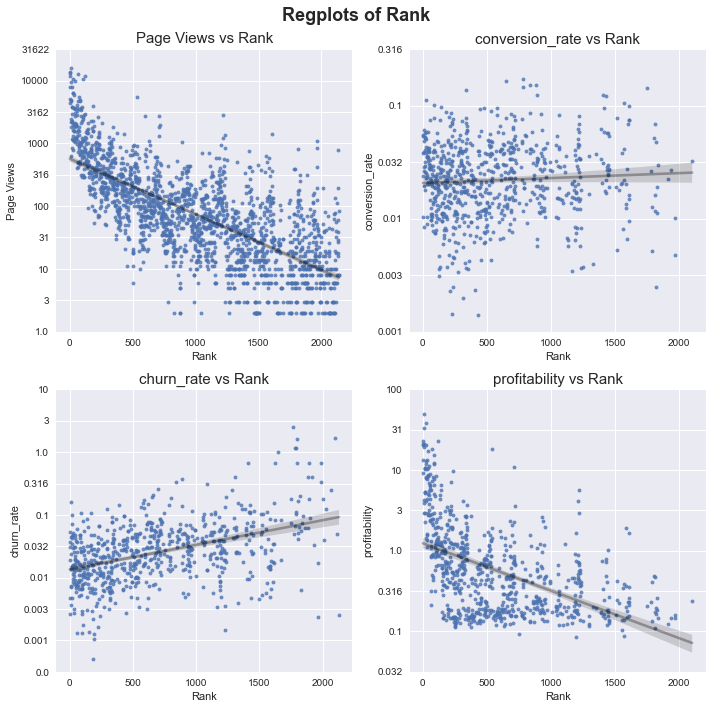

In [41]:
kpi_regplot('Rank')

### 4.1.2) RRP vs KPIs

RRP negatively affects conversion_rate, churn_rate and profitability. However since we cannot change RRP of a product we should analyze price feature which we can change in pursuit of an objective.

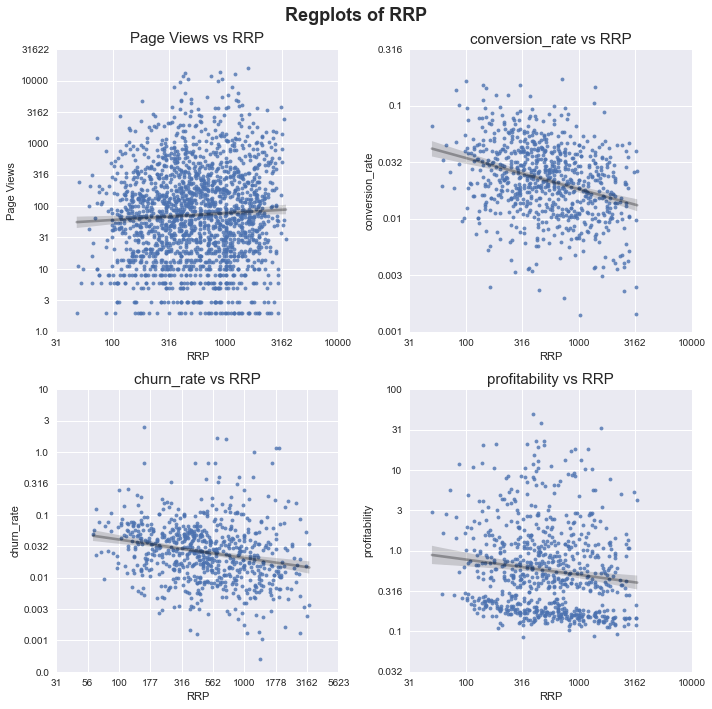

In [42]:
kpi_regplot('RRP')

### 4.1.3) Price vs KPIs

Price negatively affects conversion_rate. It also has a slight negative effect on churn_rate and profitability. We may track the conversion_rates of higher price products and may think of reducing its price to increase their Order counts.

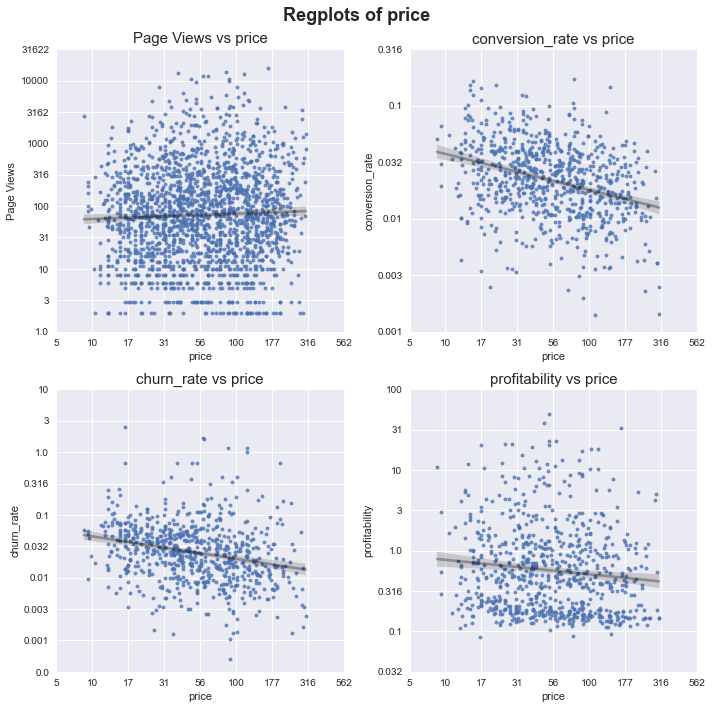

In [43]:
kpi_regplot('price')

### 4.1.4) Discount Rate vs KPIs

Due to sparsity of discount rate feature, we do not get a healthy analysis.

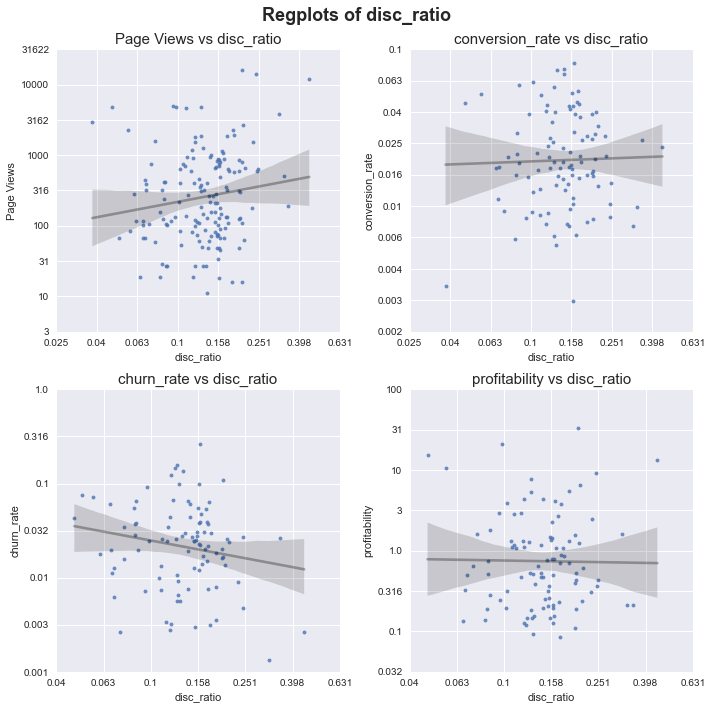

In [44]:
kpi_regplot('disc_ratio')

### 4.1.5) Price to RRP Ratio vs KPIs

Price to RRP ratio positively affects both conversion_rate and profitability. It seems like most of the profit lies on products with higher price to RRP ratio.

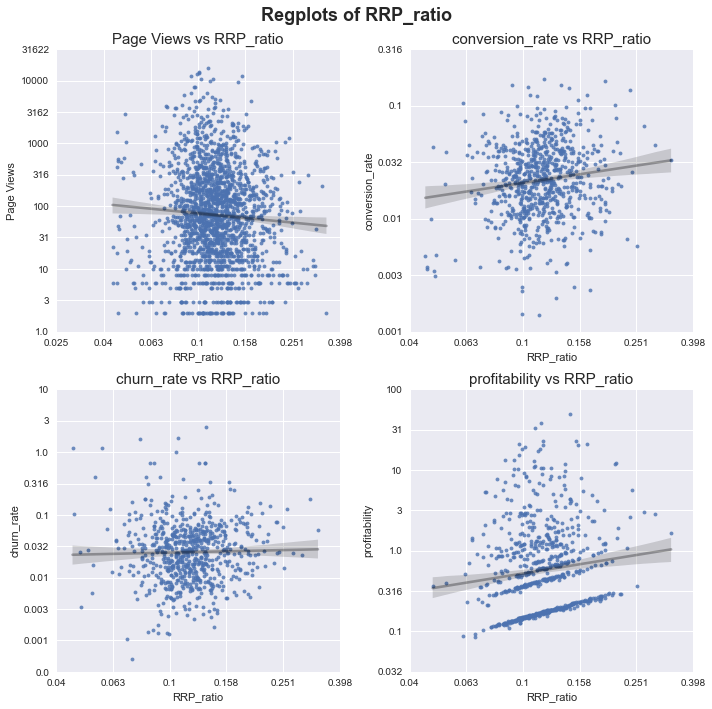

In [45]:
kpi_regplot('RRP_ratio')

## 4.2) Categorical Features vs KPIs

In [46]:
def kpi_boxplot(cat_col):
    
    #Get top 10 categories with non-zero Page Views
    mask = df['Page Views'] != 0
    df_plot = df[mask].copy()
    
    print(df_plot[cat_col].value_counts()[:10])
    categories = df_plot[cat_col].value_counts()[:10].index

    mask = df_plot[cat_col].isin(categories)
    df_plot = df_plot[mask].copy()

    fig = plt.figure(figsize = (14,8))
    for i,kpi_col in enumerate(kpi_cols):
        #Remove 0s in kpi columns to reduce sparsity
        mask = df_plot[kpi_col] != 0
        df_plot = df_plot[mask]
        
        df_plot = df_plot.sort_values(cat_col)
           
        plt.subplot(2,2,i+1)
        ax = sns.boxplot(x = df_plot[cat_col], y = np.log10(df_plot[kpi_col]))
        
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([round(10**i,3) if (i < 0.1) else int(10**i) for i in ax.get_yticks()])
        plt.xticks(rotation = 30)
        ax.set_title(f'{kpi_col} vs {cat_col}', fontsize = 15)
        
    
    fig.suptitle(f'Boxplots of {cat_col}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()
    return

### 4.2.1) Brand vs KPIs

It can be concluded that most of the profit is generated with Apple, Samsung and Sony products. We may think of promoting those brands to increase our profitability. In the churn rate plot, HP branded products have a much higher churn_rate compared to other brands. It may be beneficial to think of better covered insurance policy for HP products.

apple        260
samsung      110
sony         102
asus          91
acer          88
hp            78
dell          68
lenovo        64
microsoft     54
canon         53
Name: Brand, dtype: int64


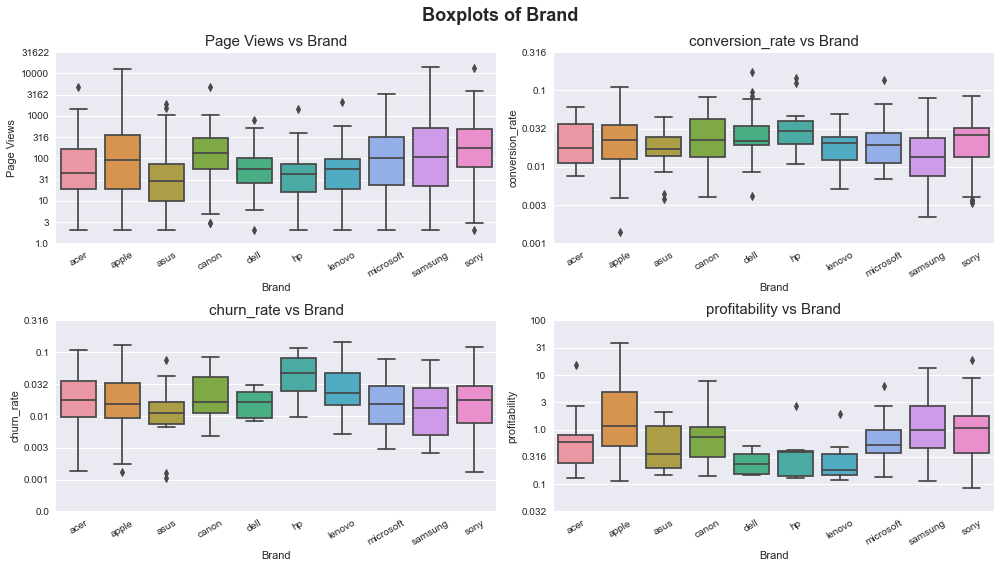

In [47]:
kpi_boxplot('Brand')

### 4.2.2) Category 1 vs KPIs

Surprisingly the products under drones, e-mobility and gaming-and-vr categories have higher Page Views than other categories. These 3 also produce the most profitability per product leaded by drones. This conclusion may be due to their lower product counts compared to other categories. However we see that conversion rate of e-mobility is pretty low. We may think of some promotions for e-mobility products to get their conversion rate on par with other categories.

computers             622
audio-and-music       324
cameras               284
phones-and-tablets    268
home-entertainment    158
wearables             133
smart-home             71
gaming-and-vr          69
drones                 31
e-mobility              9
Name: category_1, dtype: int64


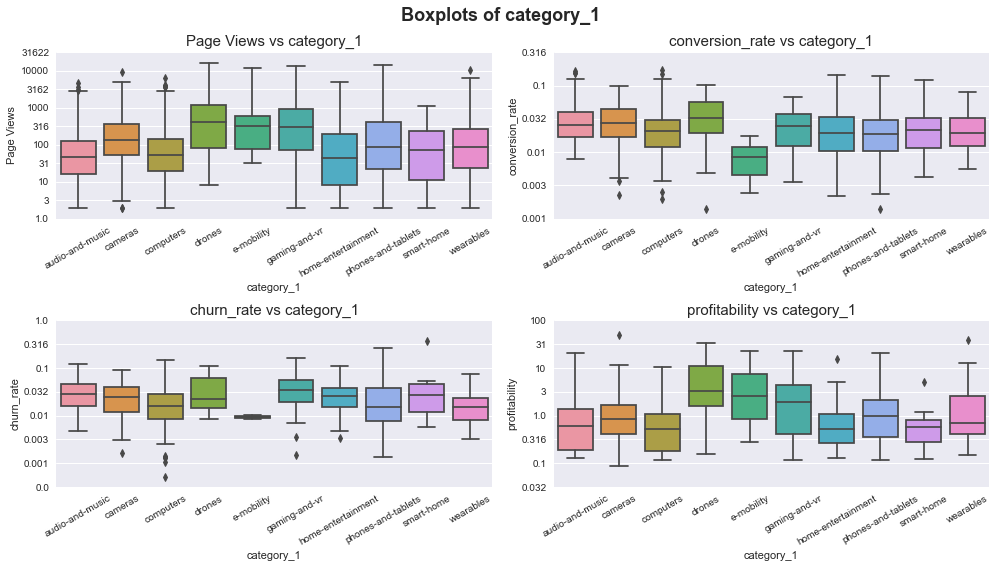

In [48]:
kpi_boxplot('category_1')

### 4.2.3) Category 2 vs KPIs

We see that smartphones has the most Page Views however they also have the lowest conversion rates. We may think of advertising other most profitable products on their product page to get benefit from their very high Page View counts. Moreover, it can be seen that headphones, hi-fi audio and lenses have higher churn rate. To prevent losses, they may be covered by a better insurance policy.

laptops             283
headphones          135
tablets             127
smartphones         119
gaming-computers    118
lenses              117
digital-cameras     102
hi-fi-audio          82
monitors             69
apple-watches        59
Name: category_2, dtype: int64


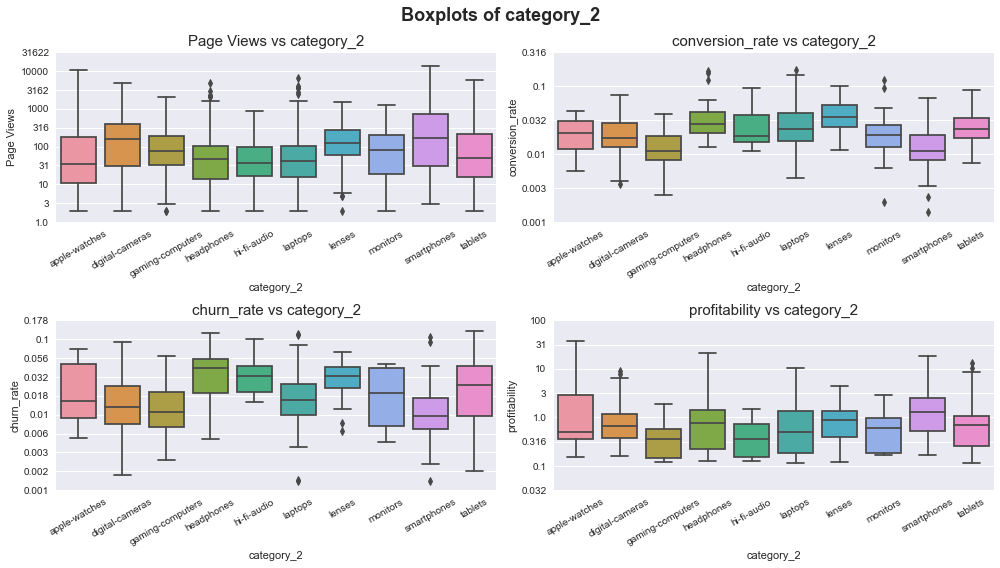

In [49]:
kpi_boxplot('category_2')

### 4.2.4) Is_Discounted vs KPIs

Existance of a discount increases Page Views as expected however surprisingly it leads to lower conversion rate. It is also probable that discount rate is applied to products with already low conversion rates.

False    1805
True      164
Name: is_discounted, dtype: int64


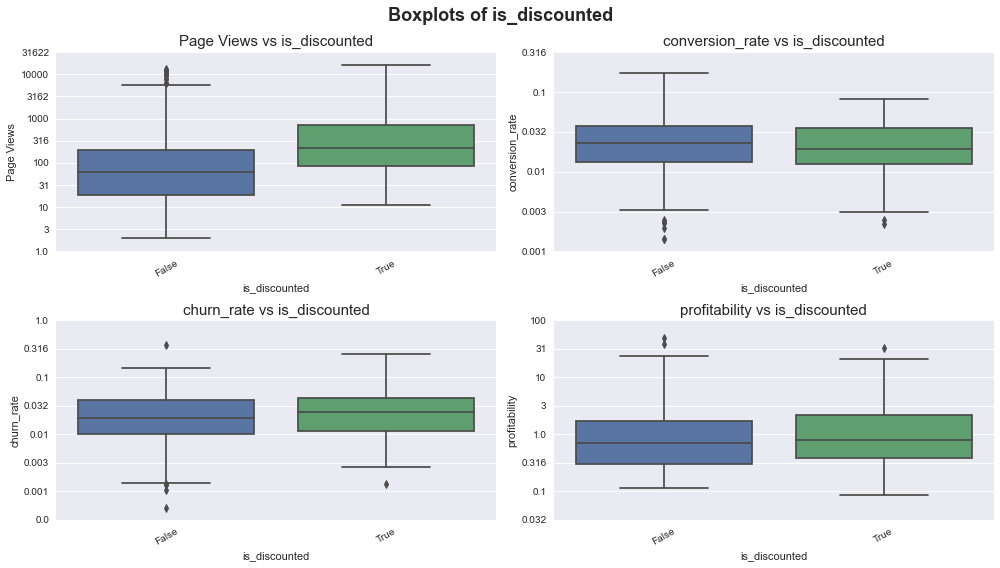

In [50]:
kpi_boxplot('is_discounted')

## 4.3) Conclusion for Bivariate Analysis of KPIs

1) Rank is a very powerful feature and very highly correlated to Page Views and it also strongly affects profitability. It may be optimized to increase rank of high profit products to increase profitability further.<br>
2) Price negatively affects conversion rate and price to RRP ratio affects profitability positively. Thus, we may increase RRP ratios of lower priced products to push profitability higher.<br>
3) Most of the profit is generated with Apple, Samsung and Sony products. We may think of promoting those brands to increase our profitability.<br>
4) HP branded products have a much higher churn_rate compared to other brands. It may be beneficial to think of better covered insurance policy for HP products. <br>
5) Surprisingly the products under drones, e-mobility and gaming-and-vr categories have higher Page Views than other categories. These 3 also produce the most profitability per product leaded by drones. This conclusion may be due to their lower product counts compared to other categories so further analysis may require.<br>
6) The conversion rate of e-mobility is pretty low. We may think of some promotions for e-mobility products to get their conversion rate on par with other categories.<br>
7) Smartphones has the most Page Views however they also have the lowest conversion rates. We may think of advertising other low price high RRP ratio complementary products such as headphones on their product page to get benefit from their very high Page View counts.<br>
8) Headphones, hi-fi audio and lenses have higher churn rate. To prevent losses, they may be covered by a better insurance policy.<br>
9) Existance of a discount increases Page Views as expected however surprisingly it leads to lower conversion rate. It is also probable that discount rate is applied to products with already low conversion rates.

# 5) Analysis of Pricing Levels

We have created PCA features capturing variance on multiple levels. These features are price, discount ratio and price-to-RRP-ratio. We have also created a feature to flag whether a product has a discount. We will analyze the relationship between numerical/categorical features between these price related features. We will follow a similar pipeline to the analysis of KPIs such as regplots for numerical relationships and boxplots for categorical relationships.

## 5.1) Numerical Features vs Pricing Metrics

disc_ratio column has a problem of sparsity therefore we will replace its 0 values with Nans.

In [51]:
input_cols = ['Brand', 'category_1', 'category_2', 'Rank','RRP']
pricing_num_cols = ['price','disc_ratio','RRP_ratio']
pricing_cat_cols = ['is_discounted']

df_pricing = df[input_cols + pricing_num_cols + pricing_cat_cols].copy()
df_pricing.head()

,Brand,category_1,category_2,Rank,RRP,price,disc_ratio,RRP_ratio,is_discounted
0,samsung,phones-and-tablets,smartphones,1.0,899.0,85.103259,2.436790e-01,0.100151,True
1,oculus,gaming-and-vr,virtual-reality,2.0,494.0,52.753888,7.315555e-15,0.116595,False
2,samsung,phones-and-tablets,smartphones,3.0,749.0,64.173162,4.449388e-01,0.092203,True
3,oculus,gaming-and-vr,virtual-reality,4.0,494.0,52.753888,1.852430e-17,0.116595,False
4,nintendo,gaming-and-vr,gaming-consoles,5.0,346.0,28.906450,0.000000e+00,0.095854,False


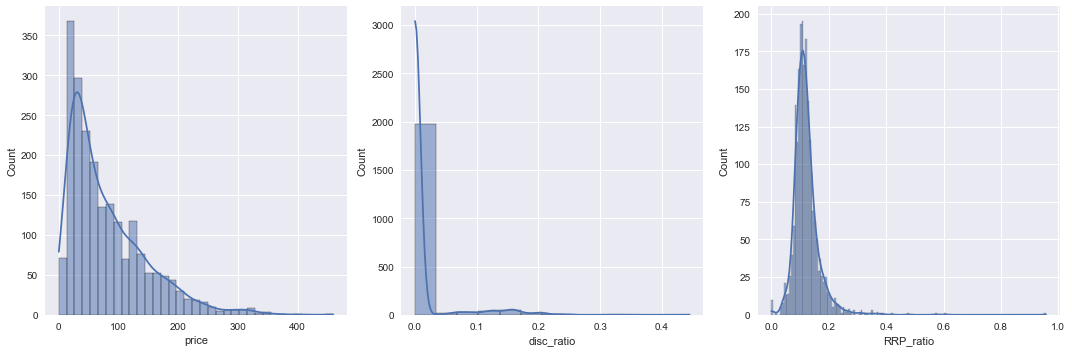

In [52]:
plt.figure(figsize = (15,5))
for i,col in enumerate(pricing_num_cols):
    
    plt.subplot(1,3,i+1)
    sns.histplot(df_pricing[col], kde=True)
plt.tight_layout()

In [53]:
#Remove sparsity of disc_ratio from plots
mask = df_pricing['disc_ratio'] < 0.001
df_pricing.loc[mask, 'disc_ratio'] = np.nan

#Fix long left tail of RRP_ratio from plts
mask = df_pricing['RRP_ratio'] > df_pricing['RRP_ratio'].quantile(0.995)
df_pricing.loc[mask, 'RRP_ratio'] = np.nan

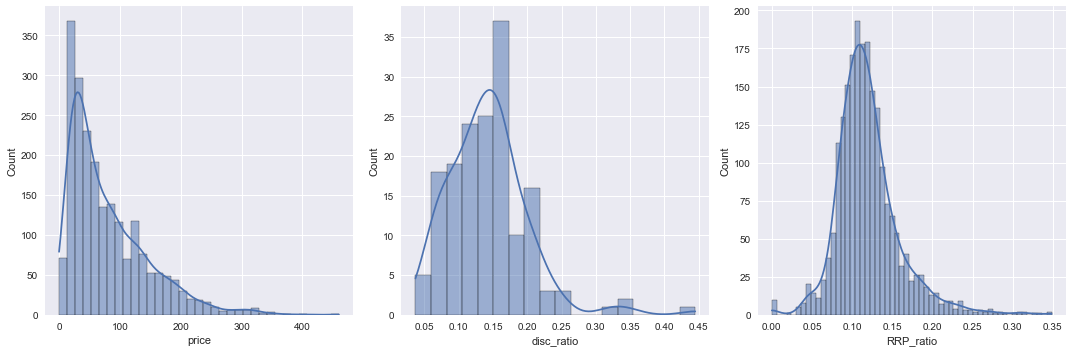

In [54]:
plt.figure(figsize = (15,5))
for i,col in enumerate(pricing_num_cols):
    
    plt.subplot(1,3,i+1)
    sns.histplot(df_pricing[col], kde=True)
plt.tight_layout()

In [55]:
def pricing_regplots(input_col):
    
    fig = plt.figure(figsize = (15,5))
    for i,col in enumerate(pricing_num_cols):

        mask = df_pricing[col] != 0
        df_plot = df_pricing[mask].copy()

        plt.subplot(1,3,i+1)
        ax = sns.regplot(x = df_plot[input_col], y = df_plot[col] , line_kws = {'color':'black', 'alpha':0.3}, 
               scatter_kws = {'s':15})
        ax.set_title(f'{col} vs {input_col}', fontsize = 15)

    fig.suptitle(f'Regplots of {input_col}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()

### 5.1.1) Rank vs Pricing Metrics

It seems like Rank has no correlation with pricing features.

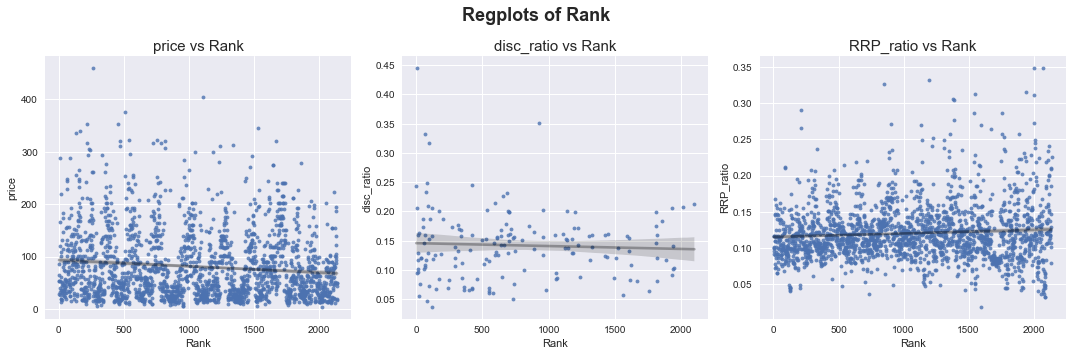

In [56]:
pricing_regplots('Rank')

### 5.1.2) RRP vs Pricing Metrics

RRP has almost perfect correlation with price which is expected. Furthermore we see that higher price to RRP ratios are mostly belong to products with lower RRP i.e. cheaper products, which is logical because it is harder to sell subscriptions with high RRP ratios on top of expensive products.

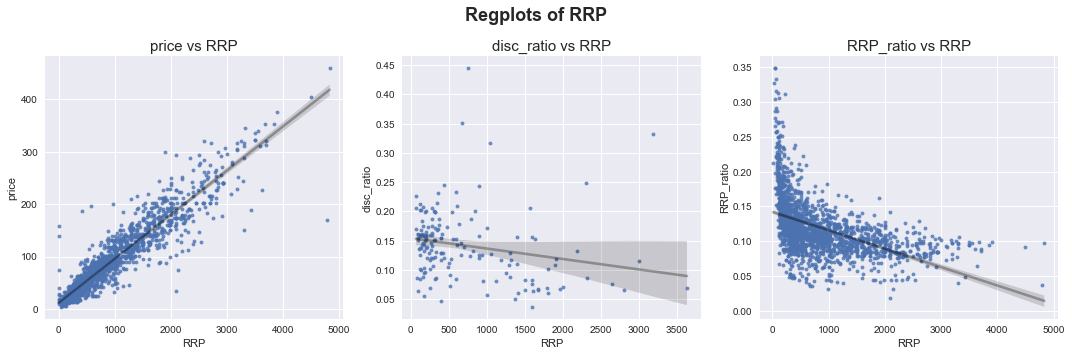

In [57]:
pricing_regplots('RRP')

### 5.1.3) Is_Discounted vs RRP

<AxesSubplot:xlabel='is_discounted', ylabel='RRP'>

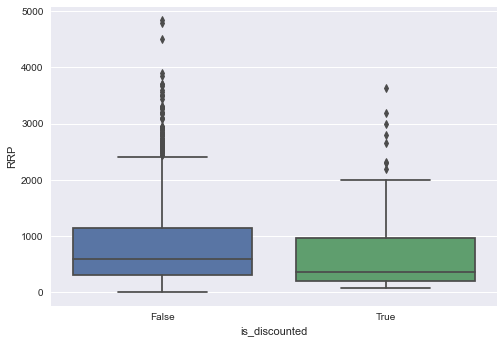

In [58]:
sns.boxplot(x = 'is_discounted', y = 'RRP', data = df_pricing)

## 5.2) Categorical Features vs Pricing Metrics

In [59]:
def pricing_boxplots(input_col):
    
    top_10_categories = df_pricing[input_col].value_counts()[:10]
    print(top_10_categories)
    categories = top_10_categories.index
    
    mask = df_pricing[input_col].isin(categories)
    df_plot = df_pricing[mask].copy()
    
    
    fig = plt.figure(figsize = (15,6))
    for i,col in enumerate(pricing_num_cols):

        mask = df_plot[col] != 0
        df_plot = df_plot[mask].copy()

        ax = plt.subplot(1,3,i+1)
        sns.boxplot(x = input_col, y = col, data = df_plot)
        plt.xticks(rotation = 45)
        ax.set_title(f'{col} vs {input_col}', fontsize = 15)
    
    fig.suptitle(f'Boxplots of {input_col}', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()

### 5.2.1) Brand vs Pricing Metrics

Sony and canon has the highest RRP_ratio compared to other brands. It is due to the fact that they have cheaper products i.e. lower price which can be also seen on the first plot. We also see that samsung has cheaper products compared to other brands.

apple        326
samsung      120
asus         107
sony         104
acer          96
hp            94
lenovo        72
dell          71
microsoft     57
canon         55
Name: Brand, dtype: int64


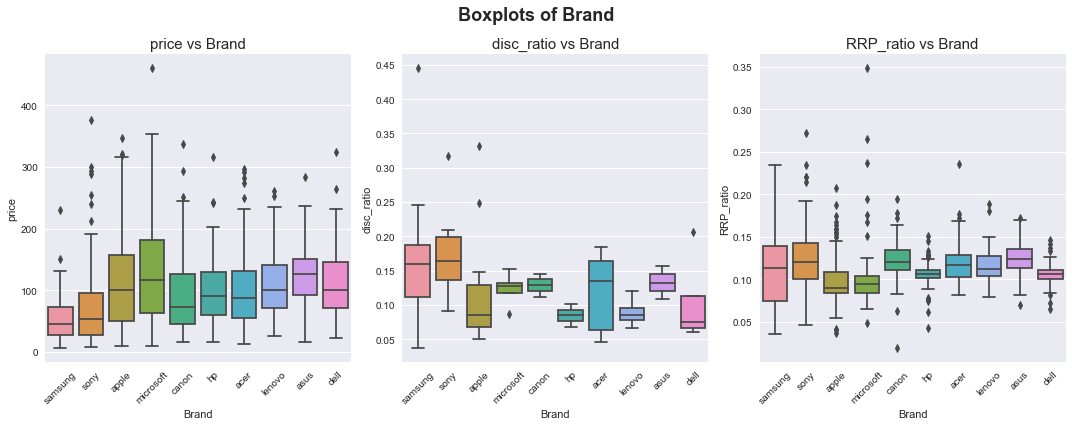

In [60]:
pricing_boxplots('Brand')

### 5.2.2) Category 1 vs Pricing Metrics

We observe that computers and drones usually have higher price compared to other main categories. Additionally e-mobility has higher price to RRP ratio than other main categories, this may be due to its cheaper products however, it may be beneficial to decrease that price to RRP ratio since we have seen while analyzing KPIs that e-mobility has one of the lowest conversion rate amongst other main categories. It may suggest that customers may feel that price is too high for e-mobility products.

computers             727
audio-and-music       342
cameras               290
phones-and-tablets    273
home-entertainment    178
wearables             146
smart-home             73
gaming-and-vr          70
drones                 31
e-mobility              9
Name: category_1, dtype: int64


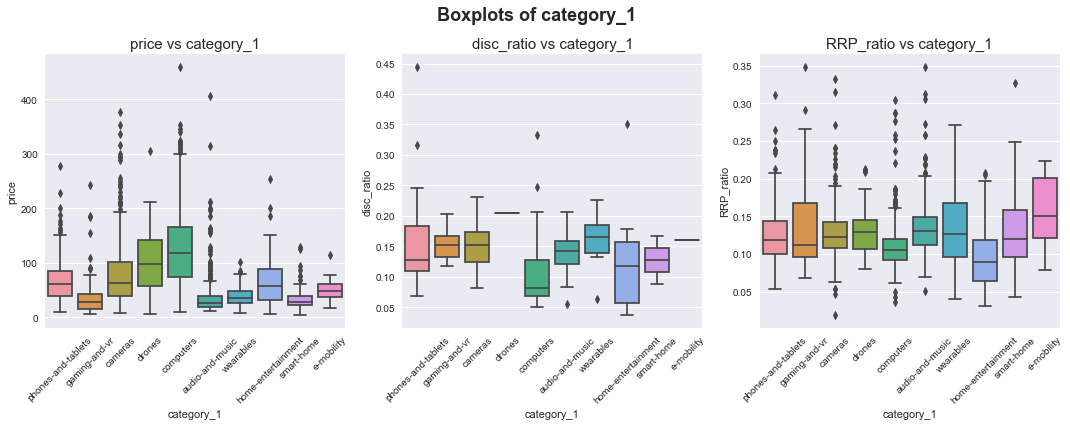

In [61]:
pricing_boxplots('category_1')

### 5.2.3) Category 2 vs Pricing Metrics

It is perceived that desktop-computers and gaming-computers have higher price compared to other sub categories. Also tv products have lower price to RRP ratio than other products.

laptops              325
headphones           144
tablets              131
gaming-computers     122
smartphones          120
lenses               120
desktop-computers    109
digital-cameras      105
hi-fi-audio           86
tv                    72
Name: category_2, dtype: int64


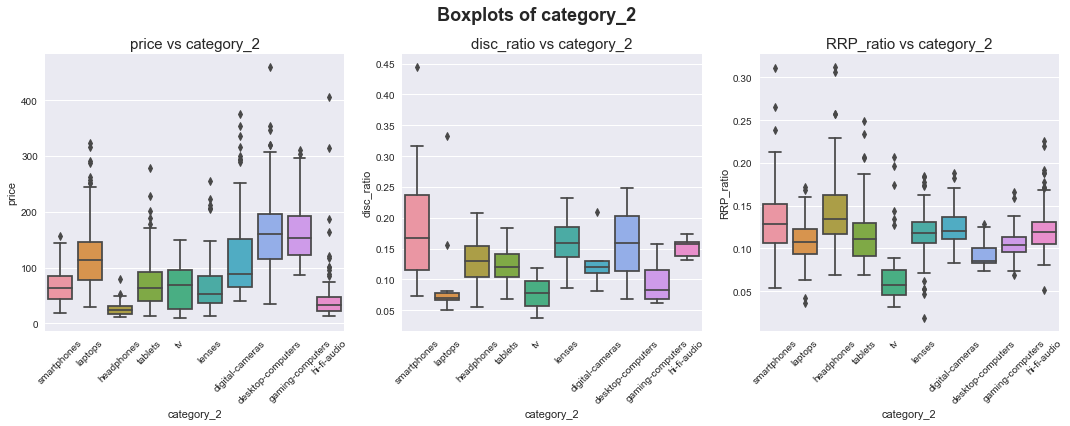

In [62]:
pricing_boxplots('category_2')

## 5.3) Categorical Features vs Is_Discounted

In [63]:
def is_discounted_barplot(input_col):
    top_10_categories = df_pricing[input_col].value_counts()[:10]
    print(top_10_categories)
    categories = top_10_categories.index

    mask = df_pricing[input_col].isin(categories)
    df_plot = df_pricing[mask].copy()

    df_plot = df_plot.groupby(input_col)['is_discounted'].mean().to_frame()


    df_plot = df_plot.loc[categories]

    sns.barplot(x = df_plot['is_discounted'], y = df_plot.index)
    plt.title('Ratio of Discounted Products', fontsize = 16)
    return

### 5.3.1) Brand vs Is_Discounted

Samsung has the most number of discounted products, we have also seen that they had higher Page Views compared to other brands, an existance of discount may have been the cause of that. However since samsung products had lower conversion rates than their counterparts it may be more profitable to bundle them with cheaper complementary products instead of high discount rates.

apple        326
samsung      120
asus         107
sony         104
acer          96
hp            94
lenovo        72
dell          71
microsoft     57
canon         55
Name: Brand, dtype: int64


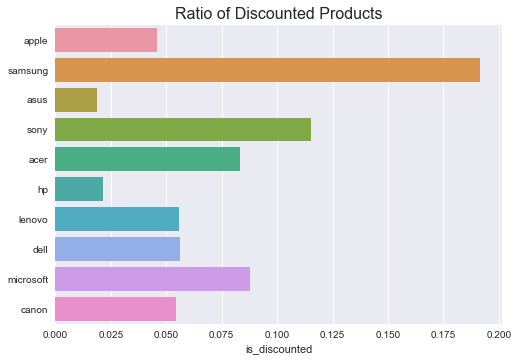

In [64]:
is_discounted_barplot('Brand')

### 5.3.2) Category 1 vs Is_Discounted

computers             727
audio-and-music       342
cameras               290
phones-and-tablets    273
home-entertainment    178
wearables             146
smart-home             73
gaming-and-vr          70
drones                 31
e-mobility              9
Name: category_1, dtype: int64


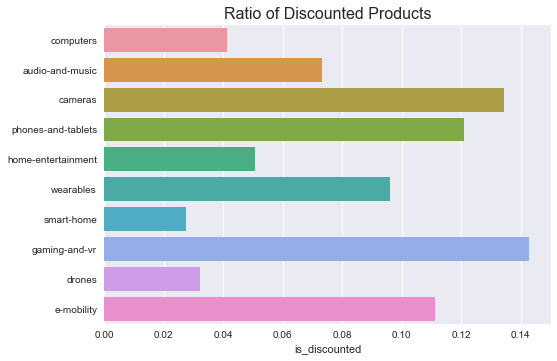

In [65]:
is_discounted_barplot('category_1')

### 5.3.4) Category 2 vs Is_Discounted

laptops              325
headphones           144
tablets              131
gaming-computers     122
smartphones          120
lenses               120
desktop-computers    109
digital-cameras      105
hi-fi-audio           86
tv                    72
Name: category_2, dtype: int64


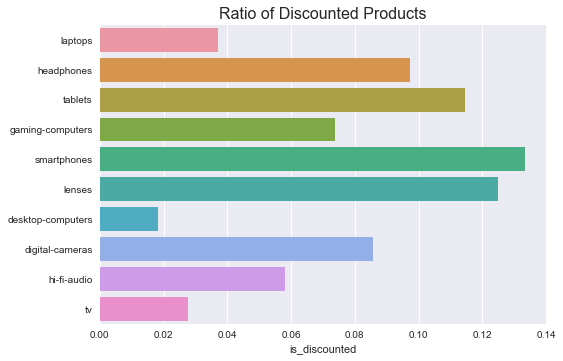

In [66]:
is_discounted_barplot('category_2')

## 5.4) Missing Values in Pricing Features

Assuming that missing prices means not offering that type of subscription, we can conclude that 64 tv products out of 72 do not have 1 month subscription.

In [67]:
df.columns
cols = ['1m_price_disc','3m_price_disc','6m_price_disc','12m_price_disc']
print(df[cols].isna().sum())
df[df['1m_price_disc'].isna()]['category_2'].value_counts()

1m_price_disc     75
3m_price_disc      1
6m_price_disc      1
12m_price_disc     1
dtype: int64


tv                    64
coffee-machine         6
smart-appliances       1
dj-equipment           1
2-in-1-laptops         1
home-cinema            1
camera-accessories     1
Name: category_2, dtype: int64

## 5.5) Pricing Levels Summary

1) It seems like Rank has no correlation with pricing features.<br>
2) RRP has almost perfect correlation with price. Furthermore we see that higher price to RRP ratios are mostly belong to products with lower RRP i.e. cheaper products, which is logical because it is harder to sell subscriptions with high RRP ratios on top of expensive products.<br>
3) Sony and canon has the highest RRP_ratio compared to other brands. It is due to the fact that they have cheaper products i.e. lower price. We also see that samsung has cheaper products compared to other brands. <br>
4) Computers and drones usually have higher price compared to other main categories. Additionally e-mobility has higher price to RRP ratio than other main categories, this may be due to its cheaper products however, it may be beneficial to decrease that price to RRP ratio since we had seen while analyzing KPIs that e-mobility has one of the lowest conversion rate amongst other main categories. It may suggest that customers may feel that price is too high for e-mobility products.<br>
5) Desktop-computers and gaming-computers have higher price compared to other sub categories. Also tv products have lower price to RRP ratio than other products.<br>
6) Samsung has the most number of discounted products, we had also seen that they had higher Page Views compared to other brands, an existance of discount may have been the cause of that. However since samsung products had lower conversion rates than their counterparts it may be more profitable to bundle them with cheaper complementary products such as headphones instead of high discount rates. <br>
7) Assuming that missing prices means not offering that type of subscription, we can conclude that 64 tv products out of 72 do not have 1 month subscription.

# 6) Multivariate Analysis of KPIs

We will try to predict KPIs by building a regression model. As regressor we will use CatBoostRegressor in consequence of its powerful categorical encoding method for high cardinality categorical features (in our case Brand and category_2) which prevents overfitting and works well. Another benefit of using a boosting algorithm is that they do not require scaling. First we will split whole data into train and test dataset where %20 of the data will be test dataset. Then we will fit a CatBoostRegressor with 5-fold cross-validation on training dataset.<br><br>
The scoring method will be mean-absolute-error (MAE). The reason why is first, KPI metrics do not have a normal distribution so using scoring functions like mean-squared-error would put too much emphasis on outlier or extreme values. The second reason is that it gives a metric similar to target unit which means that MAE being 200 for Page Views target would indicate a 200 view deviation between prediction and target on average.<br><br>
Additionally we will also look at dummy scores to evaluate whether our model is capturing any valuable information or it is just overfitting or learning the noise.<br><br>
Lastly we will analyze shap values of each model and will try to gain insights by our multivariate analysis which may give more information than bivariate analysis thanks to showing which features are more important and which are not.

## 6.1) Shap Values Analysis of CatBoostRegressor

In [68]:
input_cols = ['Brand', 'category_1', 'category_2', 'Rank', 'RRP', 'price', 'disc_ratio', 'RRP_ratio']

When we check the cardinality of categorical features, we see that we may use one-hot encoding for category_1 however since we have a small dataset it would be better to apply Catboost's built-in encoding method to keep it as just 1 single feature and reduce the effects of curse of dimensionality.

In [69]:
for col in ['Brand', 'category_1', 'category_2']:
    print(len(df[col].unique()))

191
10
43


In [70]:
def train_model(target):
    
    input_cols = ['Brand', 'category_1', 'category_2', 'Rank', 'RRP', 'price', 'disc_ratio', 'RRP_ratio']

    df_input = df[input_cols + [target]].copy()

    #Drop the sparse data
    mask = df[target].notna()
    df_input = df_input[mask]

    x_train, x_test, y_train, y_test = train_test_split(df_input[input_cols], df_input[target],
                                                        test_size = 0.2, random_state = 145 )
    
    regressor = CatBoostRegressor(cat_features = [0,1,2], one_hot_max_size = 5, verbose = 0)
    
    search_space =   {
                'learning_rate': loguniform(1e-3,5*1e-1),
                'iterations': range(10,100,10),
                'depth': range(2,10),
                }

    search = RandomizedSearchCV(regressor, search_space, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5,
                           random_state = 145, n_jobs = 8)
    results = search.fit(x_train, y_train)
    
    print('model train score =', results.best_score_)
    
    
    #Check dummy scores
    dummy = DummyRegressor(strategy = 'median')
    print('dummy train score =',cross_val_score(dummy, x_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error',
                                               n_jobs = 8).mean())
    
    #Evaluate on test data
    best_estimator = results.best_estimator_
    best_estimator.fit(x_train,y_train)
    print('model test score =',-mean_absolute_error(y_test, best_estimator.predict(x_test)))
    dummy.fit(x_train,y_train)
    print('dummy test score =',-mean_absolute_error(y_test, dummy.predict(x_test)))

    return results, best_estimator, x_train, y_train


### 6.1.1) Page Views

Our model has performed better than dummy model. Thus we can use it to analyze shap values.

In [71]:
start = time.time()
results, model_1, x_1, y_1 = train_model('Page Views')
print(time.time()-start)

model train score = -215.23413765591198
dummy train score = -311.3158542615041
model test score = -197.007133254575
dummy test score = -223.93457943925233
113.0819947719574


Red values mean higher values for that feature and blue ones mean lower values. As we can see the most effective predictor for Page Views is Rank and as Rank values go higher i.e. to the lower rankings, Page View is affected negatively. Moreover category_1 and category_2 also had strong effect on Page Views so we will check their shap values for their top 10 most common categories.

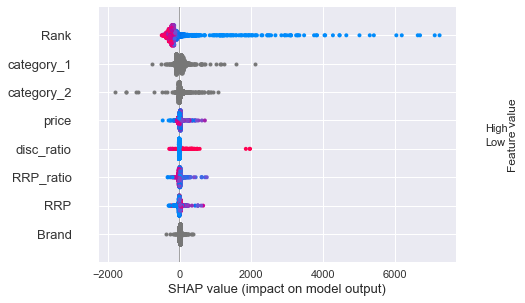

In [72]:
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(x_1)
shap.summary_plot(shap_values, x_1)

shap.dependence_plot() function were throwing error so I had to write the plot by myself.

In [73]:
def shap_plot_categorical(colname, shap_values , x):

    # def shap_plot_categorical(colname):
    df_shap = pd.DataFrame(shap_values, columns = [col + '_shap' for col in x.columns], index = x.index)
    df_shap = pd.concat([x,df_shap], axis=1)

    #Select top 10 most common categories
    categories = df_shap[colname].value_counts()[:10].index
    mask = df_shap[colname].isin(categories)
    df_shap = df_shap[mask]

    df_temp = df_shap.groupby(colname)[f'{colname}_shap'].mean().reset_index()

    sns.barplot(x = f'{colname}_shap',y = colname, data =df_temp)
    return

We see that drones, e-mobility and gaming-and-vr main categories get higher interest compared to other main categories. However computer products get less views than their counterparts.

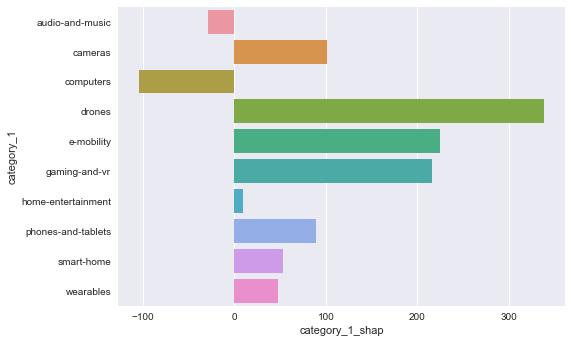

In [74]:
shap_plot_categorical('category_1', shap_values, x_1)

For the shap analysis of sub category we would say smartphones and digital-cameras has higher interest than other products.

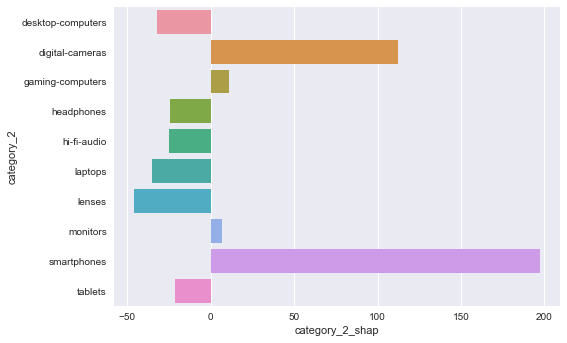

In [75]:
shap_plot_categorical('category_2', shap_values, x_1)

### 6.1.2) Conversion Rate

In [76]:
start = time.time()
results, model_2, x_2, y_2 = train_model('conversion_rate')
print(time.time()-start)

model train score = -0.010013703887317881
dummy train score = -0.011387150857809709
model test score = -0.009664981483543028
dummy test score = -0.011283107491629175
97.17835640907288


For conversion_rate it seems that most important features are Rank, price, category_1, RRP which is directly related to price and lastly category_2. Upper rank products have higher conversion_rates. Products with lower price also have higher conversion rates. We can also see that as RRP_ratio increases conversion_rate decreases.

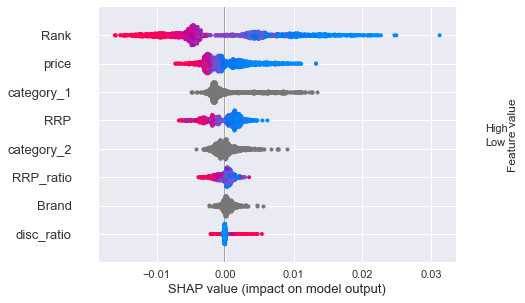

In [77]:
explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(x_2)
shap.summary_plot(shap_values, x_2)

We observe that cameras, drones and gaming-and-vr have higher conversion_rate compared to other main categories. Whereas audio-and-music, computers and lastly phones-and-tablets have lower conversion rates compared to other main categories.

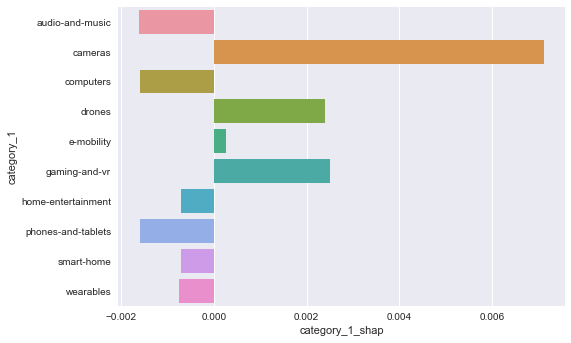

In [78]:
shap_plot_categorical('category_1', shap_values , x_2)

Our model performed worse when target is set as churn_rate, so we should take this analysis with grain of salt.

### 6.1.3) Churn Rate

In [79]:
start = time.time()
results, model_3, x_3, y_3 = train_model('churn_rate')
print(time.time()-start)

model train score = -0.027403538940125805
dummy train score = -0.020401701846575818
model test score = -0.031372033309112896
dummy test score = -0.022727618083629577
77.15161466598511


For churn_rate, the most important features are Rank, category_1, price and RRP_ratio. Lower rank products have higher churn rates. Higher price products have lower churn rates. Surprisingly, higher price to RRP_ratio products have lower churn_rates.

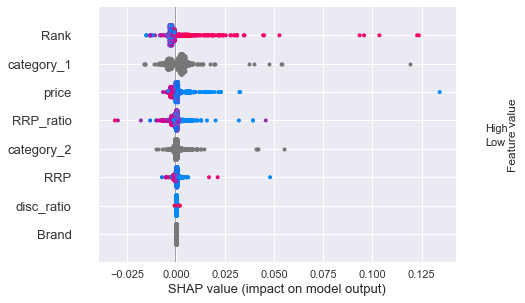

In [80]:
explainer = shap.TreeExplainer(model_3)
shap_values = explainer.shap_values(x_3)
shap.summary_plot(shap_values, x_3)

We see that home-entertainment products lead to higher churn_rate. Computers and e-mobility have lower churn_rates.

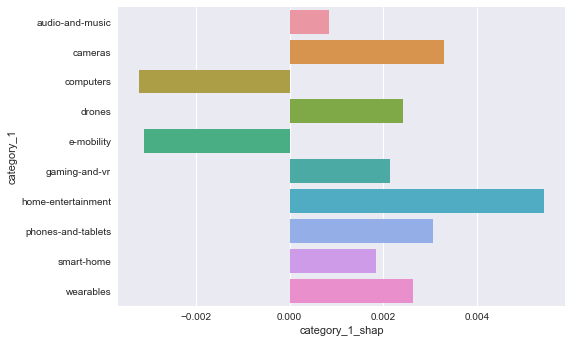

In [81]:
shap_plot_categorical('category_1', shap_values , x_3)

### 6.1.4) Profitability

In [82]:
start = time.time()
results, model_4, x_4, y_4 = train_model('profitability')
print(time.time()-start)

model train score = -0.4574166773808024
dummy train score = -0.6303200175807626
model test score = -0.43109094367907275
dummy test score = -0.46017403706999965
87.4085624217987


For profitability, the most important features are Rank, category_1 and RRP_ratio. Higher ranked products have much higher profitability. Also as RRP_ratio increases profitability increases.

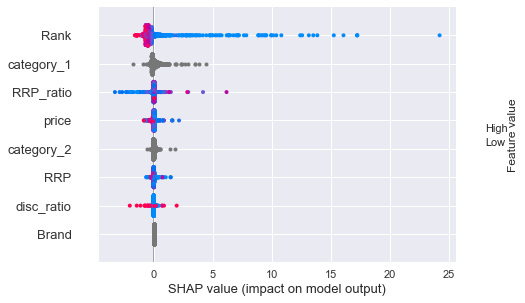

In [83]:
explainer = shap.TreeExplainer(model_4)
shap_values = explainer.shap_values(x_4)
shap.summary_plot(shap_values, x_4)

The most profitable main categories are drones, e-mobility and gaming-and-vr.

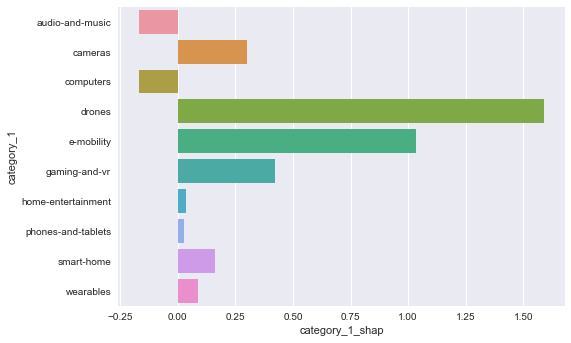

In [84]:
shap_plot_categorical('category_1', shap_values , x_4)

## 6.2) Multivariate KPI Analysis Summary

1) The most effective predictor for Page Views is Rank and top Rank products have much higher Page Views than others. Moreover category_1 and category_2 also had strong effect on Page Views. <br>
2) Drones, e-mobility and gaming-and-vr main categories get higher customer interest compared to other main categories. However computer products get less views than their counterparts.<br>
3) Smartphones and digital-cameras has higher customer interest than other products.<br>
4) For conversion_rate it seems that most important features are Rank, price, category_1, RRP which is directly related to price and lastly category_2. Upper rank products have higher conversion_rates. Products with lower price also have higher conversion rates. We can also see that as RRP_ratio increases conversion_rate decreases. <br>
5) Cameras, drones and gaming-and-vr have higher conversion_rate compared to other main categories. Whereas audio-and-music, computers and lastly phones-and-tablets have lower conversion rates compared to other main categories.<br>
6) Our model performed worse when target is set as churn rate, so we should take the analysis of churn rate with grain of salt.<br>
7) For churn_rate, the most important features are Rank, category_1, price and RRP_ratio. Lower rank products have higher churn rates. Higher price products have lower churn rates. Surprisingly, higher price to RRP_ratio products have lower churn_rates.<br>
8) Home-entertainment products lead to higher churn_rate. Computers and e-mobility have lower churn_rates.<br>
9) For profitability, the most important features are Rank, category_1 and RRP_ratio. Higher ranked products have much higher profitability. Also as RRP_ratio increases profitability increases.<br>
10) The most profitable main categories are drones, e-mobility and gaming-and-vr.<br>